# GOOGLE ANALYTICS CUSTOMER REVENUE PREDICTION

# 1.) Data Loading and Preprocessing


In [26]:
!pip install lightgbm

     |████████████████████████████████| 2.0 MB 2.3 MB/s            


In [8]:
!pip install xgboost

     |████████████████████████████████| 173.6 MB 7.3 kB/s              


In [15]:
#import libraries

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import json
import pickle
import missingno as msno
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
from sklearn import preprocessing 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb 
import xgboost as xgb
from prettytable import PrettyTable

In [16]:
#sample data display to have basic understanding  about the structure of data

df = pd.read_csv('train_v2.csv',nrows=5)
df

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552


In [17]:
#display data types

df.dtypes

channelGrouping         object
customDimensions        object
date                     int64
device                  object
fullVisitorId            int64
geoNetwork              object
hits                    object
socialEngagementType    object
totals                  object
trafficSource           object
visitId                  int64
visitNumber              int64
visitStartTime           int64
dtype: object

In [18]:
# The below function is used to preprocess the data and produce proper data frames for train and test datasets

def loadAndCreate_df(filepath,n_rows=None,usefulfeatures=[]):
    
    #Json data features are listed our here
    json_features = ['device','geoNetwork','totals','trafficSource']
    
    
    #Reading data from the given filepath with chunksizes of 100k rows in each
    train_df_chunks = pd.read_csv(filepath,
                converters = {feature:json.loads for feature in json_features},
                nrows=n_rows,
                dtype = {'fullVisitorId':'str','channelGrouping':'str','visitId':'int',
                         'visitNumber':'int','visitStartTime':'int'},
                parse_dates = ['date'],
                chunksize = 100000)
    
    #Create an empty dataframe and append chunked data to it in every iteration   
    train_df = pd.DataFrame()
    
    #Append all chunks to train_df in multiple iterations
    for df_chunk in train_df_chunks:
        df_chunk.reset_index(drop=True,inplace=True)
        
        #Normalize json features  
        for feature in json_features:
            json_flattened = json_normalize(df_chunk[feature])
            json_flattened_features = []
            
            for each_col in json_flattened.columns:
                json_flattened_features.append(feature+"."+each_col)
                
            json_flattened.columns = json_flattened_features
            
            #drop the existing json data and append the normalized data
            df_chunk = df_chunk.drop(feature,axis=1).merge(json_flattened,left_index=True,right_index=True)
        
        #By default all features are selected if no feature is sent as input
        if len(usefulfeatures)==0:
            usefulfeatures = df_chunk.columns
            
        #select the useful features into useful data frame
        useful_df = df_chunk[usefulfeatures]
        train_df = pd.concat([train_df,useful_df],axis=0).reset_index(drop=True)
        print(train_df.shape)
        del df_chunk
    return train_df

In [29]:
# select the first 100000 rows for data cleaning purpose
%time train_df = loadAndCreate_df('train_v2.csv',n_rows=100000,usefulfeatures=[])

(100000, 59)
CPU times: user 19.5 s, sys: 1.49 s, total: 21 s
Wall time: 20.9 s


In [30]:
#display existing columns before data cleaning
train_df.columns

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId', 'hits',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
 

# 2.) Data Cleaning

In [31]:
#Data cleaning includes the exclusion of constant and redundant columns data
constant_columns = []
for each_col in train_df.columns:
    if train_df[each_col].nunique()==1:
        constant_columns.append(each_col)

In [32]:
#custom dimensions and hits contains non-useful data
useless_features = constant_columns + ['customDimensions','hits']

In [33]:
#display useful features data after data cleaning
usefulfeatures = list(set(train_df.columns)-set(useless_features))

In [34]:
#Load entire train data after data cleaning
%time train_df = loadAndCreate_df('train_v2.csv',usefulfeatures=usefulfeatures)

(100000, 34)
(200000, 34)
(300000, 34)
(400000, 34)
(500000, 34)
(600000, 34)
(700000, 34)
(800000, 34)
(900000, 34)
(1000000, 34)
(1100000, 34)
(1200000, 34)
(1300000, 34)
(1400000, 34)
(1500000, 34)
(1600000, 34)
(1700000, 34)
(1708337, 34)
CPU times: user 7min 4s, sys: 35.2 s, total: 7min 40s
Wall time: 8min 54s


In [35]:
#Load entire test data after data cleaning
%time test_df = loadAndCreate_df('test_v2.csv',usefulfeatures=usefulfeatures)

(100000, 34)
(200000, 34)
(300000, 34)
(400000, 34)
(401589, 34)
CPU times: user 1min 46s, sys: 5.7 s, total: 1min 52s
Wall time: 2min 19s


### Plot missing values plot to eliminate useless features

<AxesSubplot:>

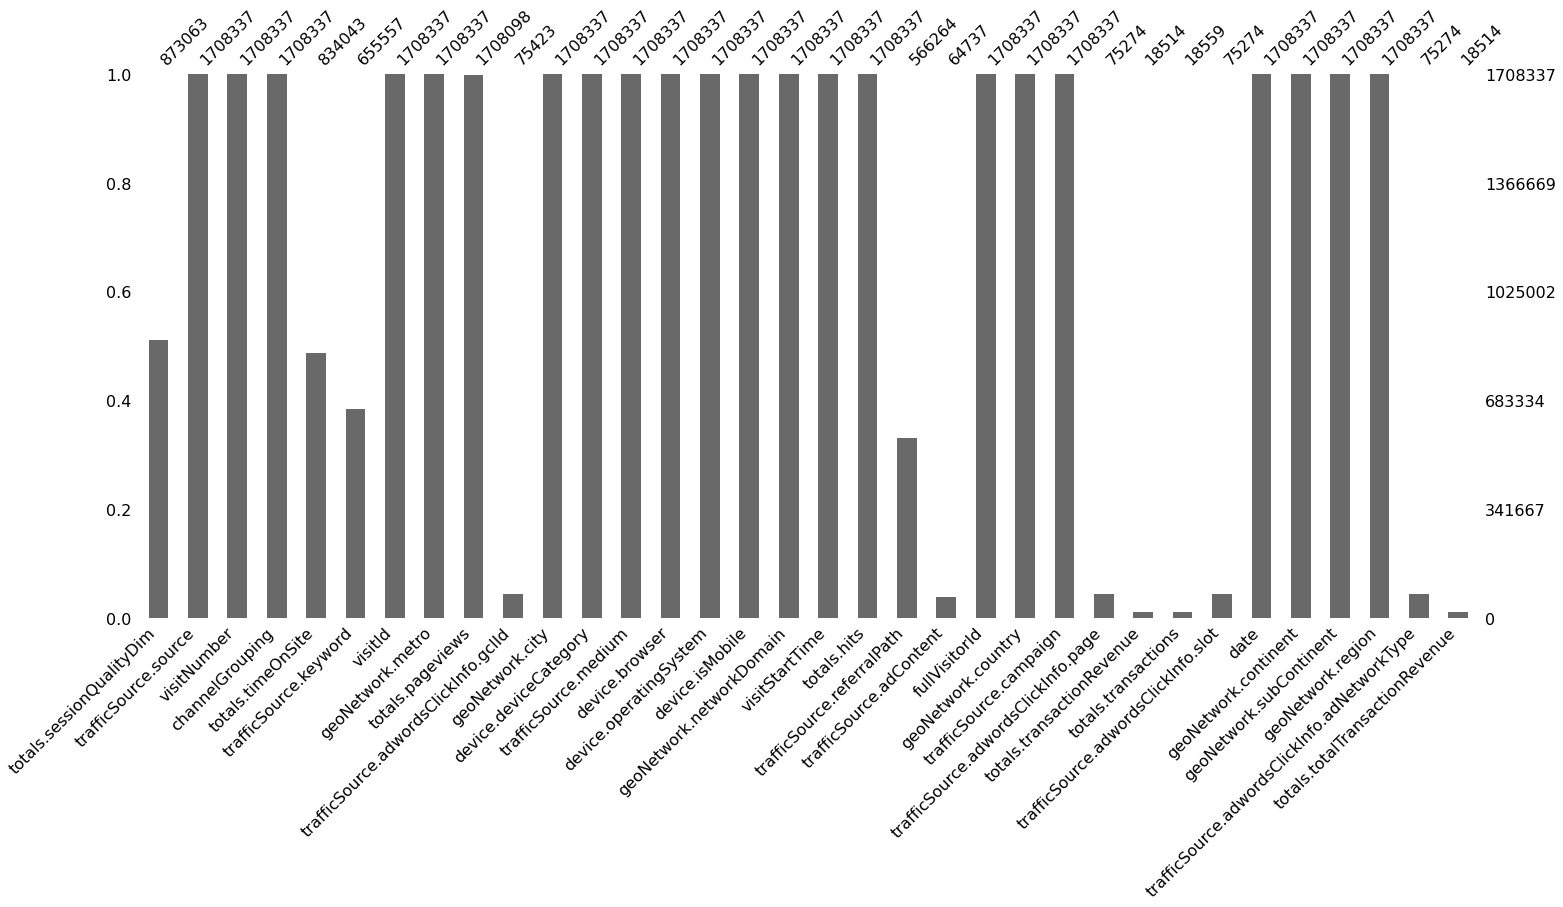

In [82]:
msno.bar(train_df)

In [36]:
#conacat few other useless features
useless_features = useless_features + ['trafficSource.campaign','trafficSource.adContent','trafficSource.adwordsClickInfo.gclId',
                                      'trafficSource.adwordsClickInfo.page','trafficSource.adwordsClickInfo.slot',
                                       'trafficSource.adwordsClickInfo.adNetworkType','visitId']

In [37]:
#display useful features data after data cleaning
usefulfeatures = list(set(train_df.columns)-set(useless_features))
usefulfeatures

['trafficSource.source',
 'visitNumber',
 'totals.hits',
 'date',
 'visitStartTime',
 'channelGrouping',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'totals.sessionQualityDim',
 'totals.totalTransactionRevenue',
 'trafficSource.referralPath',
 'device.deviceCategory',
 'geoNetwork.city',
 'geoNetwork.metro',
 'totals.timeOnSite',
 'device.browser',
 'trafficSource.keyword',
 'totals.pageviews',
 'trafficSource.medium',
 'geoNetwork.continent',
 'totals.transactionRevenue',
 'device.isMobile',
 'fullVisitorId',
 'geoNetwork.country',
 'geoNetwork.subContinent',
 'totals.transactions',
 'device.operatingSystem']

In [38]:
#drop few other useless features from train dataframe
train_df=train_df.drop(['trafficSource.campaign','trafficSource.adContent','trafficSource.adwordsClickInfo.gclId',
                                      'trafficSource.adwordsClickInfo.page','trafficSource.adwordsClickInfo.slot',
                                       'trafficSource.adwordsClickInfo.adNetworkType','visitId'], axis=1)

In [39]:
#drop few other useless features from test dataframe
test_df=test_df.drop(['trafficSource.campaign','trafficSource.adContent','trafficSource.adwordsClickInfo.gclId',
                                      'trafficSource.adwordsClickInfo.page','trafficSource.adwordsClickInfo.slot',
                                       'trafficSource.adwordsClickInfo.adNetworkType','visitId'], axis=1)

In [40]:
#print train and test shapes
print(train_df.shape)
print(test_df.shape)

(1708337, 27)
(401589, 27)


In [41]:
#save train and test dataframes into pickle file
train_df.to_pickle('preprocessed_train_df')
test_df.to_pickle('preprocessed_test_df')

In [42]:
#load train and test dataframes
train_df = pd.read_pickle('preprocessed_train_df')
test_df = pd.read_pickle('preprocessed_test_df')

In [43]:
#save train and test dataframes as csv files
train_df.to_csv('preprocessed_train_df.csv')
test_df.to_csv('preprocessed_test_df.csv')

In [44]:
#columns in train data frame
train_df.columns

Index(['trafficSource.source', 'visitNumber', 'totals.hits', 'date',
       'visitStartTime', 'channelGrouping', 'geoNetwork.networkDomain',
       'geoNetwork.region', 'totals.sessionQualityDim',
       'totals.totalTransactionRevenue', 'trafficSource.referralPath',
       'device.deviceCategory', 'geoNetwork.city', 'geoNetwork.metro',
       'totals.timeOnSite', 'device.browser', 'trafficSource.keyword',
       'totals.pageviews', 'trafficSource.medium', 'geoNetwork.continent',
       'totals.transactionRevenue', 'device.isMobile', 'fullVisitorId',
       'geoNetwork.country', 'geoNetwork.subContinent', 'totals.transactions',
       'device.operatingSystem'],
      dtype='object')

In [45]:
#columns in test data frame
test_df.columns

Index(['trafficSource.source', 'visitNumber', 'totals.hits', 'date',
       'visitStartTime', 'channelGrouping', 'geoNetwork.networkDomain',
       'geoNetwork.region', 'totals.sessionQualityDim',
       'totals.totalTransactionRevenue', 'trafficSource.referralPath',
       'device.deviceCategory', 'geoNetwork.city', 'geoNetwork.metro',
       'totals.timeOnSite', 'device.browser', 'trafficSource.keyword',
       'totals.pageviews', 'trafficSource.medium', 'geoNetwork.continent',
       'totals.transactionRevenue', 'device.isMobile', 'fullVisitorId',
       'geoNetwork.country', 'geoNetwork.subContinent', 'totals.transactions',
       'device.operatingSystem'],
      dtype='object')

# 3.) Exploratory Data Analysis

In [32]:
#Font dictionary is defined for EDA plots

font = {'color':'black','weight':'bold','size':20}
tick_color = '#104E8B'

## i.)Transaction Revenue Analysis

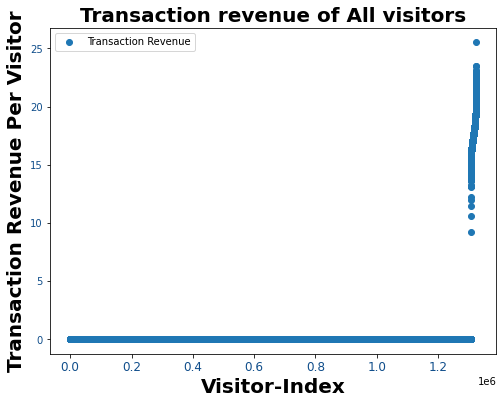

In [34]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')

revenuePerVisitor = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index() 

plt.figure(figsize=(8,6))
plt.scatter(range(len(revenuePerVisitor)), np.sort(np.log1p(revenuePerVisitor["totals.transactionRevenue"].values)))
plt.xlabel('Visitor-Index',fontdict=font)
plt.ylabel('Transaction Revenue Per Visitor',fontdict=font)
plt.xticks(fontsize=12, color=tick_color)
plt.yticks(color=tick_color)
plt.title('Transaction revenue of All visitors',fontdict=font)
plt.legend(['Transaction Revenue'])
plt.show()

In [35]:
revenue_list = np.array(revenuePerVisitor["totals.transactionRevenue"])
reveneue_customer_percent = round(((len(revenue_list[np.where(revenue_list!=0)])/len(revenue_list))*100),2)
print("The percentage of visitors from revenue generated is "+ str(reveneue_customer_percent)+"%")

The percentage of visitors from revenue generated is 1.22%


## Observations
- The 80/20 rule in Businesses has proven that most of the revenue will be generated by very few customers.
- So,the percentage of visitors from which revenue generated is 1.21%

## ii.) Channel grouping Analysis

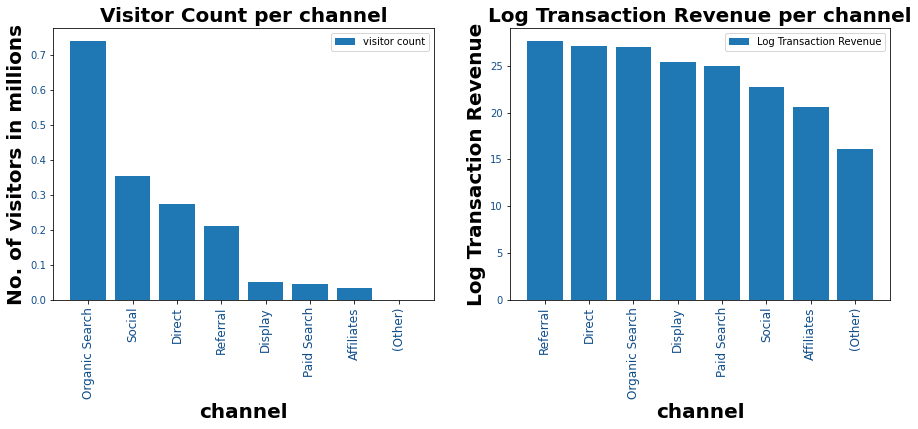

In [17]:
#plot figure
plt.figure(figsize=(15,5))

# subplot-1
cgp_count = train_df.groupby("channelGrouping")["fullVisitorId"].count().reset_index().sort_values(["fullVisitorId"],ascending=False).reset_index(drop=True)
cgp_count['fullVisitorId'] = cgp_count['fullVisitorId']/1000000

x = cgp_count["channelGrouping"]
y = cgp_count["fullVisitorId"]

plt.subplot(1,2,1)
plt.bar(x,y)
plt.xlabel('channel',fontdict=font)
plt.ylabel('No. of visitors in millions',fontdict=font)
plt.xticks(rotation=90,fontsize=12, color=tick_color)
plt.yticks(color=tick_color)
plt.title("Visitor Count per channel",fontdict=font)
plt.legend(['visitor count'])

# subplot-2
cgp_revenue = train_df.groupby("channelGrouping")["totals.transactionRevenue"].sum().reset_index().sort_values(["totals.transactionRevenue"],ascending=False).reset_index(drop=True)
cgp_revenue['totals.transactionRevenue'] = np.log1p(cgp_revenue["totals.transactionRevenue"].values)

x = cgp_revenue["channelGrouping"]
y = cgp_revenue["totals.transactionRevenue"]

plt.subplot(1,2,2)
plt.bar(x,y)
plt.xlabel('channel',fontdict=font)
plt.ylabel('Log Transaction Revenue',fontdict=font)
plt.xticks(rotation=90,fontsize=12, color=tick_color)
plt.yticks(color=tick_color)
plt.title("Log Transaction Revenue per channel",fontdict=font)
plt.legend(['Log Transaction Revenue'])
plt.show()


## Observations
- From the above plot we can see that most of the revenue is generated through Referral,Direct, organic search
- Even though the number of visits are less through referral and direct the revneue generated is huge.So, Analytics team can invest less money for direct and referral and can generate high revenue.
- If we can observe the revenue generated through Referral is huge because any purchase of the product through referral codes or links will have an offer on the product which makes customers to purchase that product with high probability.

## iii.) Web Browsing Analysis

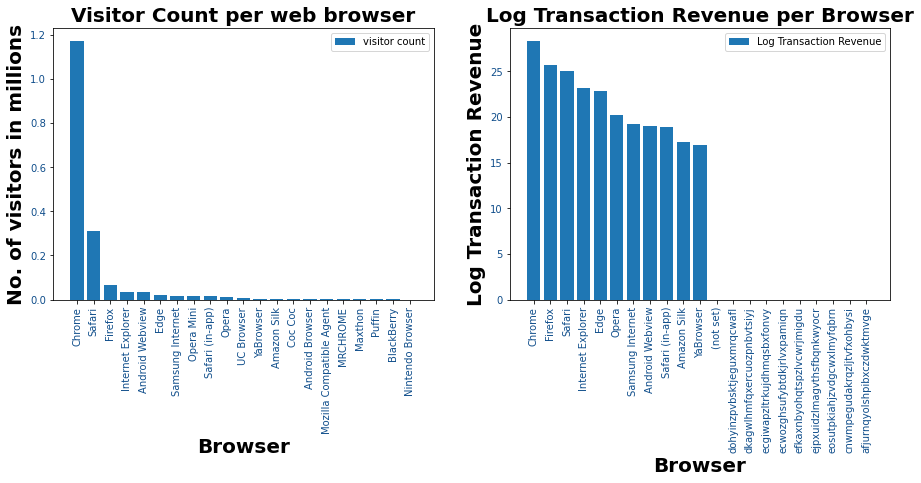

In [18]:
#plot figure
plt.figure(figsize=(15,5))

# subplot-1
browser_count = train_df.groupby("device.browser")["fullVisitorId"].count().reset_index().sort_values(["fullVisitorId"],ascending=False).reset_index(drop=True)
x_temp = np.array(browser_count["device.browser"])
y_temp = np.array(browser_count["fullVisitorId"])

#filtering web browser visitor count with atleast 100 count for finding huge revenue happened through particular web browser
index=np.where(y_temp>100)
x=x_temp[index]
y=y_temp[index]

#In bar plot visitor count scale will be in millions
y=y/1000000

plt.subplot(1,2,1)
plt.bar(x,y)
plt.xlabel('Browser',fontdict=font)
plt.ylabel('No. of visitors in millions',fontdict=font)
plt.xticks(rotation=90,fontsize=10,color=tick_color)
plt.yticks(color=tick_color)
plt.title("Visitor Count per web browser",fontdict=font)
plt.legend(['visitor count'])

# subplot-2
browser_revenue = train_df.groupby("device.browser")["totals.transactionRevenue"].sum().reset_index().sort_values(["totals.transactionRevenue"],ascending=False).reset_index(drop=True)
browser_revenue['totals.transactionRevenue'] = np.log1p(browser_revenue["totals.transactionRevenue"].values)

x_temp = np.array(browser_revenue["device.browser"])
y_temp = np.array(browser_revenue["totals.transactionRevenue"])

x=x_temp[index]
y=y_temp[index]


plt.subplot(1,2,2)
plt.bar(x,y)
plt.xlabel('Browser',fontdict=font)
plt.ylabel('Log Transaction Revenue',fontdict=font)
plt.xticks(rotation=90,fontsize=10,color=tick_color)
plt.yticks(color=tick_color)
plt.title("Log Transaction Revenue per Browser",fontdict=font)
plt.legend(['Log Transaction Revenue'])
plt.show()


## Observations
- From the above plot we can see that huge revenue is generated through chrome, firefox, safari etc
- Important observation is that even after having less number of visits through safari, firefox the revenue generated through these browsers are on par with revneue generated through chrome browser.So, Analytics team can invest less money on safari, firefox and can generate huge revenue.

## iv.) Operating system Analysis

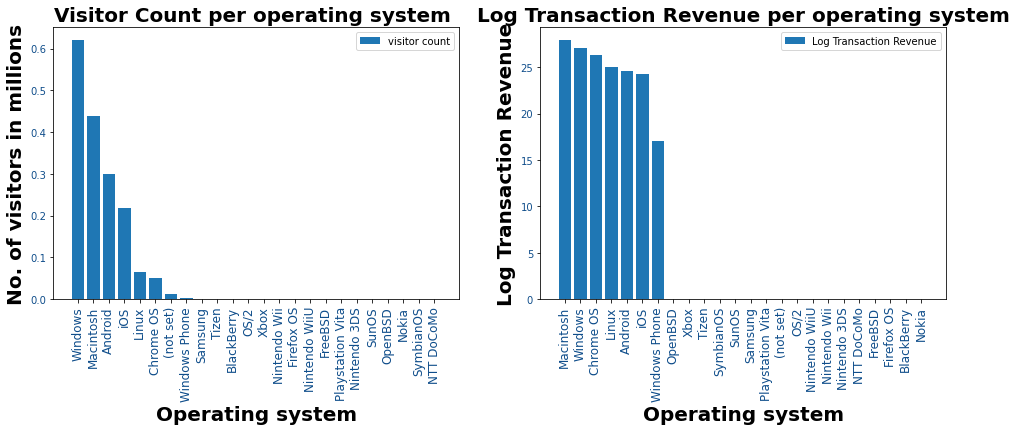

In [19]:
#plot figure
plt.figure(figsize=(16,5))

# subplot-1
os_count = train_df.groupby("device.operatingSystem")["fullVisitorId"].count().reset_index().sort_values(["fullVisitorId"],ascending=False).reset_index(drop=True)
x = os_count["device.operatingSystem"]
y = os_count["fullVisitorId"]

#In bar plot visitor count scale will be in millions
y=y/1000000

plt.subplot(1,2,1)
plt.bar(x,y)
plt.xlabel('Operating system',fontdict = font)
plt.ylabel('No. of visitors in millions',fontsize=20,fontdict = font)
plt.xticks(rotation=90,fontsize=12, color=tick_color)
plt.yticks(color=tick_color)
plt.title("Visitor Count per operating system ",fontdict=font)
plt.legend(['visitor count'])

# subplot-2
os_revenue = train_df.groupby("device.operatingSystem")["totals.transactionRevenue"].sum().reset_index().sort_values(["totals.transactionRevenue"],ascending=False).reset_index(drop=True)
os_revenue['totals.transactionRevenue'] = np.log1p(os_revenue["totals.transactionRevenue"].values)

x = os_revenue["device.operatingSystem"]
y = os_revenue["totals.transactionRevenue"]

plt.subplot(1,2,2)
plt.bar(x,y)
plt.xlabel('Operating system',fontdict=font)
plt.ylabel('Log Transaction Revenue',fontdict=font)
plt.xticks(rotation=90,fontsize=12,color=tick_color)
plt.yticks(color=tick_color)
plt.title("Log Transaction Revenue per operating system",fontdict=font)
plt.legend(['Log Transaction Revenue'])
plt.show()


## Observations
- From the above plot we can see that most of the revneue is generated through Macintosh,windows,chromeOS,Linux,Android,ios
- Important observation from the above plot is even though we have less number of visits in linux, android, ios the revenue generated through Android,ios are on par with macintosh and windows.
- The revenue generated through Android,ios,windows phone is huge even though there are less number of visits because one the major reason could be as these operating systems are mostly present in mobile devices. So, most number of purchases of costly products could have been done through mobile devices with these operating systems.

## v.) Device category Analysis

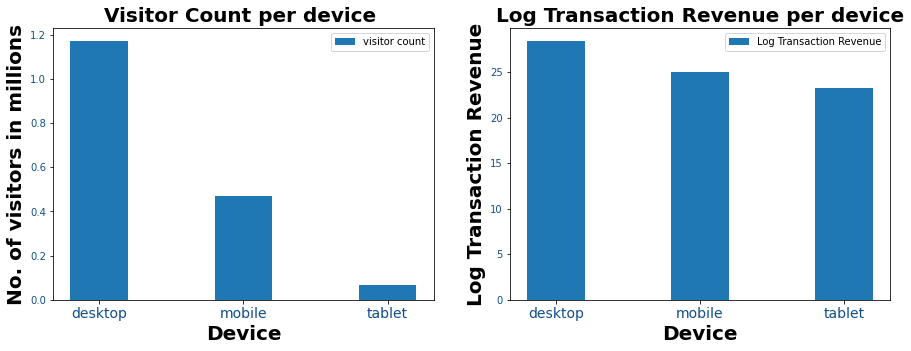

In [20]:
#plot figure
plt.figure(figsize=(15,5))

# subplot-1
device_count = train_df.groupby("device.deviceCategory")["fullVisitorId"].count().reset_index().sort_values(["fullVisitorId"],ascending=False).reset_index(drop=True)
x = device_count["device.deviceCategory"]
y = device_count["fullVisitorId"]

#In bar plot visitor count scale will be in millions
y=y/1000000

plt.subplot(1,2,1)
plt.bar(x,y,width=0.4)
plt.xlabel('Device',fontdict=font)
plt.ylabel('No. of visitors in millions',fontdict=font)
plt.xticks(fontsize=14, color=tick_color)
plt.yticks(color=tick_color)
plt.title("Visitor Count per device ",fontdict=font)
plt.legend(['visitor count'])

# subplot-2
device_revenue = train_df.groupby("device.deviceCategory")["totals.transactionRevenue"].sum().reset_index().sort_values(["totals.transactionRevenue"],ascending=False).reset_index(drop=True)
device_revenue['totals.transactionRevenue'] = np.log1p(device_revenue["totals.transactionRevenue"].values)

x = device_revenue["device.deviceCategory"]
y = device_revenue["totals.transactionRevenue"]

plt.subplot(1,2,2)
plt.bar(x,y,width=0.4)
plt.xlabel('Device',fontdict=font)
plt.ylabel('Log Transaction Revenue',fontdict=font)
plt.xticks(fontsize=14, color=tick_color)
plt.yticks(color=tick_color)
plt.title("Log Transaction Revenue per device",fontdict=font)
plt.legend(['Log Transaction Revenue'])
plt.show()


## Observations
- From the above plot we can observe that the number of visits and generated revenue both are high through desktop
- Even though the number of visits on mobile device and tablet very less when compared to desktop the revenue generated through them are very high
- Especially the number of visits through tablet are very less but the revenue generated through it is huge.

## vi.) Mobile vs Non-Mobile Analysis

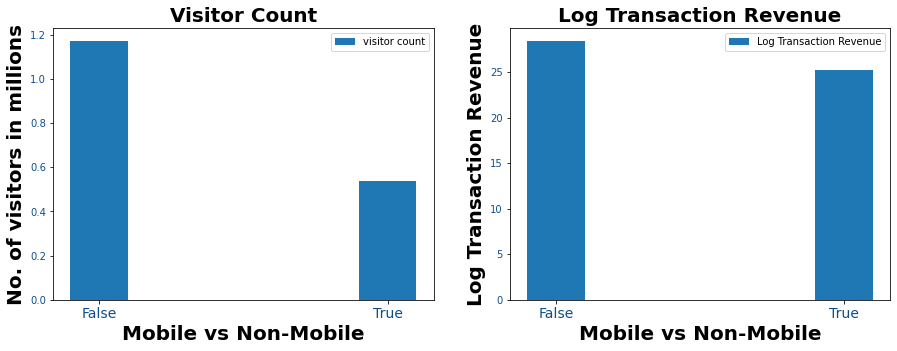

In [21]:
#plot figure
plt.figure(figsize=(15,5))

# subplot-1
mobile_count = train_df.groupby("device.isMobile")["fullVisitorId"].count().reset_index().sort_values(["fullVisitorId"],ascending=False).reset_index(drop=True)

x = mobile_count["device.isMobile"]
x=[str(x[i]) for i in range(len(x))]
y = mobile_count["fullVisitorId"]

#In bar plot visitor count scale will be in millions
y=y/1000000

plt.subplot(1, 2, 1)
plt.bar(x,y,width=0.2)
plt.xlabel('Mobile vs Non-Mobile',fontdict=font)
plt.ylabel('No. of visitors in millions',fontdict=font)
plt.xticks(fontsize=14, color=tick_color)
plt.yticks(color=tick_color)
plt.title("Visitor Count",fontdict=font)
plt.legend(['visitor count'])

# subplot-2
mobile_revenue = train_df.groupby("device.isMobile")["totals.transactionRevenue"].sum().reset_index().sort_values(["totals.transactionRevenue"],ascending=False).reset_index(drop=True)
mobile_revenue['totals.transactionRevenue'] = np.log1p(mobile_revenue["totals.transactionRevenue"].values)

x = mobile_revenue["device.isMobile"]
x=[str(x[i]) for i in range(len(x))]
y = mobile_revenue["totals.transactionRevenue"]

plt.subplot(1, 2, 2)
plt.bar(x,y,width=0.2)
plt.xlabel('Mobile vs Non-Mobile',fontdict=font)
plt.ylabel('Log Transaction Revenue',fontdict=font)
plt.xticks(fontsize=14, color=tick_color)
plt.yticks(color=tick_color)
plt.title("Log Transaction Revenue",fontdict=font)
plt.legend(['Log Transaction Revenue'])
plt.show()

## Observations
- From the above plot vistor count of mobile is almost less than half of the non-mobile devices.
- The revenue generated through the mobile device is huge and almost more than 80% of revenue generated through non-mobile device.

## vii.) Continent Analysis

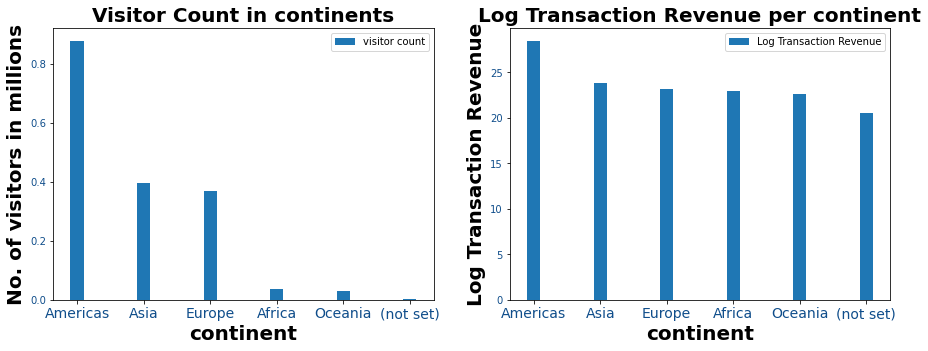

In [22]:
#plot figure
plt.figure(figsize=(15,5))

# subplot-1
continent_count = train_df.groupby("geoNetwork.continent")["fullVisitorId"].count().reset_index().sort_values(["fullVisitorId"],ascending=False).reset_index(drop=True)

x = continent_count["geoNetwork.continent"]
y = continent_count["fullVisitorId"]

#In bar plot visitor count scale will be in millions
y=y/1000000

plt.subplot(1, 2, 1)
plt.bar(x,y,width=0.2)
plt.xlabel('continent',fontdict=font)
plt.ylabel('No. of visitors in millions',fontdict=font)
plt.xticks(fontsize=14, color=tick_color)
plt.yticks(color=tick_color)
plt.title("Visitor Count in continents",fontdict=font)
plt.legend(['visitor count'])

# subplot-2
continent_revenue = train_df.groupby("geoNetwork.continent")["totals.transactionRevenue"].sum().reset_index().sort_values(["totals.transactionRevenue"],ascending=False).reset_index(drop=True)
continent_revenue['totals.transactionRevenue'] = np.log1p(continent_revenue["totals.transactionRevenue"].values)

x = continent_revenue["geoNetwork.continent"]
y = continent_revenue["totals.transactionRevenue"]

plt.subplot(1, 2, 2)
plt.bar(x,y,width=0.2)
plt.xlabel('continent',fontdict=font)
plt.ylabel('Log Transaction Revenue',fontdict=font)
plt.xticks(fontsize=14, color=tick_color)
plt.yticks(color=tick_color)
plt.title("Log Transaction Revenue per continent",fontdict=font)
plt.legend(['Log Transaction Revenue'])
plt.show()

## Observations
- From the above plot we can observe that the visitor count and transaction revenue is huge in America
- From Asia and Europe even though the visitor count is almost half of vistor count in america but the revenue generated through them is around 80% of revenue generated by america.
- Even though the vistor count is less from Africa,ocenaia and others the revenue generated in those continents is huge and on par with Asia and europe.

## viii.) Traffic source Analysis

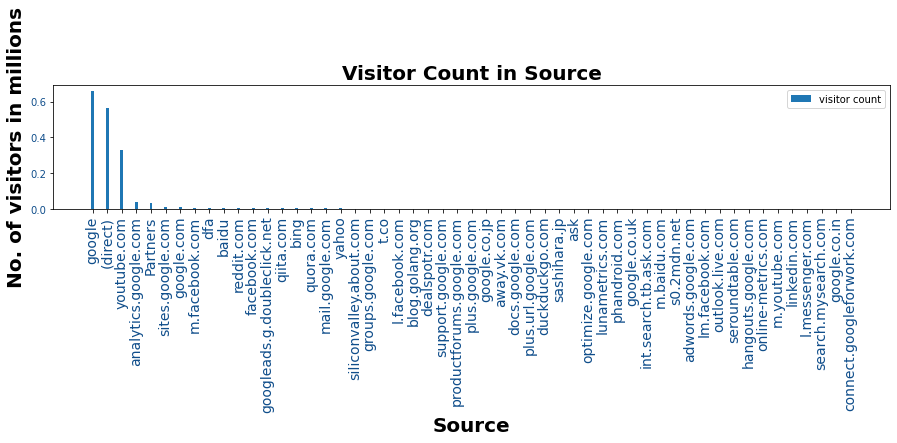

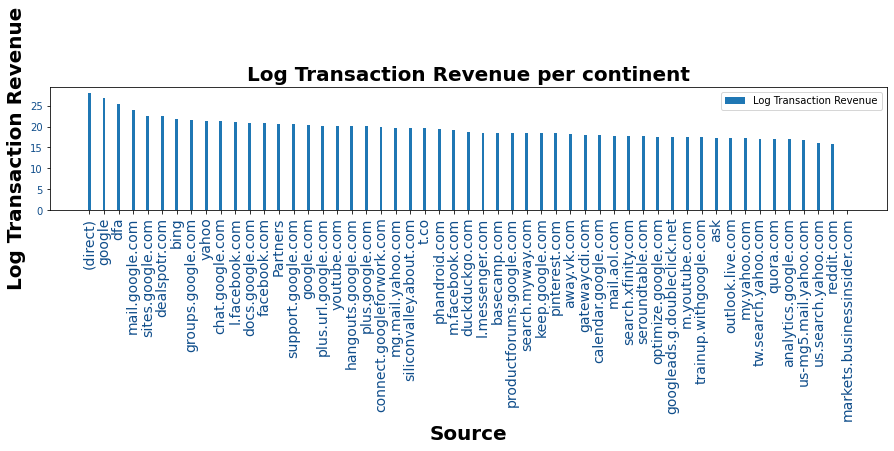

In [23]:
#plot figure
plt.figure(figsize=(15,5))

# subplot-1
trafficSource_count = train_df.groupby("trafficSource.source")["fullVisitorId"].count().reset_index().sort_values(["fullVisitorId"],ascending=False).reset_index(drop=True)

x_temp = np.array(trafficSource_count["trafficSource.source"])
y_temp = np.array(trafficSource_count["fullVisitorId"])

#filtering Traffic source with atleast 100 count for finding huge revenue happened through which traffic source
index=np.where(y_temp>100)
x=x_temp[index]
y=y_temp[index]

#In bar plot visitor count scale will be in millions
y=y/1000000

plt.subplot(2, 1, 1)
plt.bar(x,y,width=0.2)
plt.xlabel('Source',fontdict=font)
plt.ylabel('No. of visitors in millions',fontdict=font)
plt.xticks(rotation=90, fontsize=14, color=tick_color)
plt.yticks(color=tick_color)
plt.title("Visitor Count in Source",fontdict=font)
plt.legend(['visitor count'])
plt.show()

plt.figure(figsize=(15,5))
# subplot-2
trafficSource_revenue = train_df.groupby("trafficSource.source")["totals.transactionRevenue"].sum().reset_index().sort_values(["totals.transactionRevenue"],ascending=False).reset_index(drop=True)
trafficSource_revenue['totals.transactionRevenue'] = np.log1p(trafficSource_revenue["totals.transactionRevenue"].values)

x_temp = np.array(trafficSource_revenue["trafficSource.source"])
y_temp = np.array(trafficSource_revenue["totals.transactionRevenue"])

x=x_temp[index]
y=y_temp[index]

plt.subplot(2, 1, 2)
plt.bar(x,y,width=0.2)
plt.xlabel('Source',fontdict=font)
plt.ylabel('Log Transaction Revenue',fontdict=font)
plt.xticks(rotation=90, fontsize=14, color=tick_color)
plt.yticks(color=tick_color)
plt.title("Log Transaction Revenue per continent",fontdict=font)
plt.legend(['Log Transaction Revenue'])
plt.show()

## Observations
- The vistor count is huge for google,yotube.com and revenue generated is also huge.
- The most important observation is even though the visitor count is very very less and almost null when compared to google and youtube sources but the revenue generated through other sources is huge and seems like the revenue generated plot is almost uniformly distributed among multiple sources.

## ix.) Trend Analysis

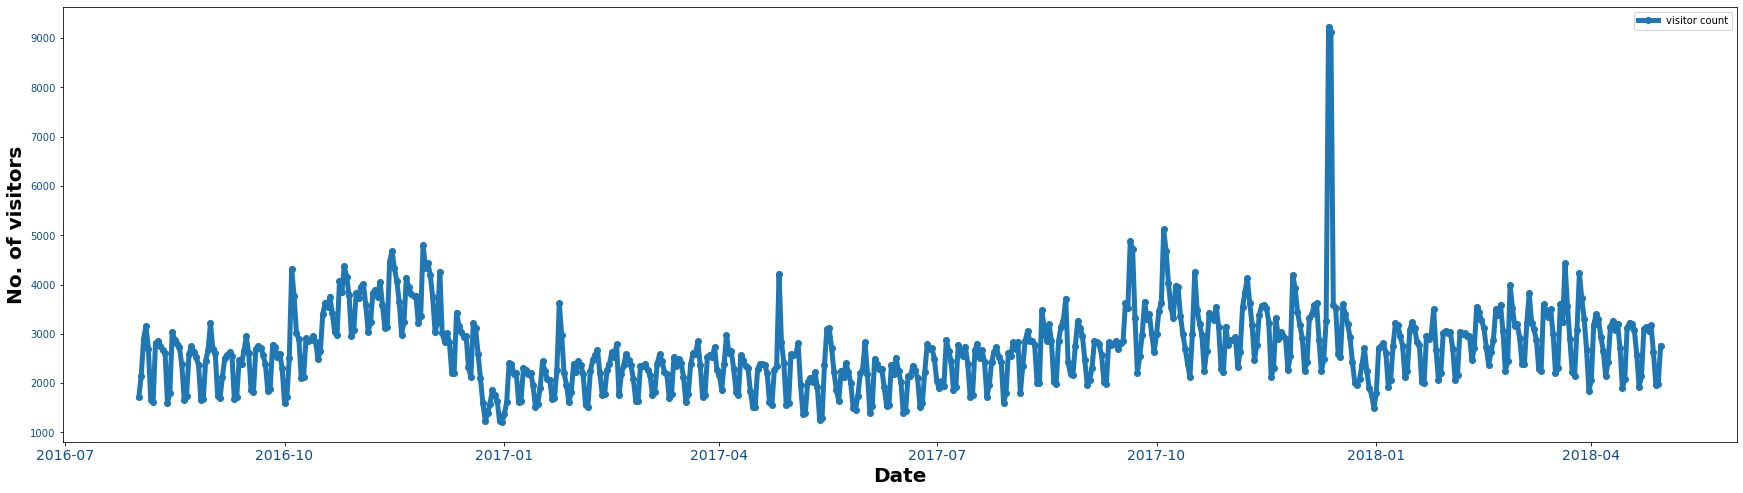

In [24]:
plt.figure(figsize=(30,8))

df_date = train_df.groupby('date').count()
df_date.reset_index(inplace=True)
plt.plot_date(x=df_date['date'], y=df_date['fullVisitorId'],linestyle='solid',linewidth=5)
plt.xlabel('Date',fontdict=font)
plt.ylabel('No. of visitors',fontdict=font)
plt.xticks(fontsize=14, color=tick_color)
plt.yticks(color=tick_color)
plt.legend(['visitor count'])
plt.autoscale(True)
plt.show()

## Observations
- From the above plot we can observe that there is huge spike in month of december-2017 and also around 11th and 12th month of 2016.
- The transactions and reveneue generated on these periods could be very huge when compared to other days so, analytics team can invest money on these days for promotion strategies and can provide reasonable deals for customers.

# 4.) Featurization

In [46]:
train_df.dtypes

trafficSource.source                      object
visitNumber                                int64
totals.hits                               object
date                              datetime64[ns]
visitStartTime                             int64
channelGrouping                           object
geoNetwork.networkDomain                  object
geoNetwork.region                         object
totals.sessionQualityDim                  object
totals.totalTransactionRevenue            object
trafficSource.referralPath                object
device.deviceCategory                     object
geoNetwork.city                           object
geoNetwork.metro                          object
totals.timeOnSite                         object
device.browser                            object
trafficSource.keyword                     object
totals.pageviews                          object
trafficSource.medium                      object
geoNetwork.continent                      object
totals.transactionRe

## 4.1 Impute Missing Values

In [7]:
train_df["totals.transactionRevenue"].fillna(0, inplace=True)

## 4.2 convert numerical features to float

In [8]:
numerical_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime",'totals.timeOnSite','totals.transactions', 'totals.transactionRevenue' ]    
for col in numerical_cols:
    train_df[col].fillna(0,inplace=True)
    train_df[col] = train_df[col].astype(float)
    test_df[col].fillna(0,inplace=True)
    test_df[col] = test_df[col].astype(float)

## 4.3 Label Encoding for categorical features

In [6]:
categorical_columns = ["channelGrouping", 
                       "device.browser", "device.deviceCategory", "device.operatingSystem", 
                       "geoNetwork.city", "geoNetwork.continent", "geoNetwork.country", "geoNetwork.metro",
                       "geoNetwork.networkDomain", "geoNetwork.region", "geoNetwork.subContinent", 
                       "trafficSource.keyword", "trafficSource.medium",
                       "trafficSource.referralPath", "trafficSource.source",
                       "totals.sessionQualityDim" ]
           
for col in categorical_columns:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    with open('label_encoders/'+col+'.pkl', 'wb') as file:
         pickle.dump(lbl, file)
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))
    print(col+' label encoding is done....')

channelGrouping label encoding is done....
device.browser label encoding is done....
device.deviceCategory label encoding is done....
device.operatingSystem label encoding is done....
geoNetwork.city label encoding is done....
geoNetwork.continent label encoding is done....
geoNetwork.country label encoding is done....
geoNetwork.metro label encoding is done....
geoNetwork.networkDomain label encoding is done....
geoNetwork.region label encoding is done....
geoNetwork.subContinent label encoding is done....
trafficSource.keyword label encoding is done....
trafficSource.medium label encoding is done....
trafficSource.referralPath label encoding is done....
trafficSource.source label encoding is done....
totals.sessionQualityDim label encoding is done....


In [10]:
with open('label_encoders/channelGrouping.pkl', 'rb') as file:
    lbl = pickle.load(file)

## 4.4 Time series featurization of train data

In [88]:
def getTrainDataFrameWithTimeFrame(df, n):

        # n=1 - 1st Timeframe
        #Train data - Aug 1st 2016 to Jan 15th 2017 (168 days)
        #Test data - Mar 2nd 2017 to May 3'rd 2017 (62 days)
        
        # n=2 - 2nd Timeframe
        #Train data - Jan 16st 2017 to Jul 2nd 2017 (168 days)
        #Test data - Aug 17th 2017 to Oct 18th 2017 (62 days)
        
        # n=3 - 3rd Timeframe
        #Train data - Jul 3rd 2017 to Dec 17th 2017 (168 days)
        #Test data - Feb 1st 2018 to Apr 4th 2018 (62 days)
        
        # n=4 - 4th Timeframe
        #Train data - Dec 18th 2017 to Jun 4th 2018 (168 days)
        #Test data - Jul 20th 2018 to Sep 20th 2018 (62 days)
        
        
    #Fetch 168 days of visitors data according to given time frame number 'n' 
    #we consider this as train time frame data
    train_tf = df.loc[(df['date'] >= min(df['date']) + timedelta(days=168*(n-1))) 
                      & (df['date'] < min(df['date']) + timedelta(days=168*n))]
    
    #Fetch 62 days of visitors data according to given time frame number 'n
    #we consider this as test time frame data
    test_tf = df.loc[(df['date'] >= max(train_tf['date']) + timedelta(days = 46))
                          & (df['date'] < max(train_tf['date']) + timedelta(days = 46 + 62))]
    
    #Fetch those customers who return to the store after cooling peiod of 46 days for timeperiod of 62 days
    customers_returned = set(train_tf["fullVisitorId"]) & set(test_tf["fullVisitorId"]) # intersection
    
    #Fetch those customers who doesn't return to the store after cooling peiod of 46 days for timeperiod of 62 days
    customers_not_returned = set(train_tf["fullVisitorId"]) - set(test_tf["fullVisitorId"]) # subtraction
    

    # Fetching customers returned data along with sum of all transaction revenue amount in test frame data
    #---------------------------------------------------------------------------------------------
    customers_returned_data = test_tf[test_tf['fullVisitorId'].isin(set(customers_returned))]  
    customers_returned_transaction_data = customers_returned_data.groupby('fullVisitorId')[['totals.transactionRevenue']]\
                                          .sum().apply(np.log1p, axis=1).reset_index()
    
    customers_returned_transaction_data.rename(columns={'totals.transactionRevenue': 'revenue'}, inplace=True)
    customers_returned_transaction_data['is_returned'] = 1
     
    
    # Fetching customers not returned data and place transaction revenue amount as 0 
    #--------------------------------------
    customers_not_returned_transaction_data = pd.DataFrame()
    customers_not_returned_transaction_data['fullVisitorId'] = list(set(customers_not_returned))
    customers_not_returned_transaction_data['is_returned'] = 0
    customers_not_returned_transaction_data['revenue'] = 0
    
    #concatenate both customers_returned_transaction_data and customers_not_returned_transaction_data
    customers_transaction_data = pd.concat([customers_returned_transaction_data, customers_not_returned_transaction_data], axis=0)\
                              .reset_index(drop=True)
    
    
    #max date and min date used for featurization purpose
    train_tf_maxdate = max(train_tf['date'])
    train_tf_mindate = min(train_tf['date'])
    
    #Additional features after time series featurization for train time frame data
    train_tf = train_tf.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': [('networkDomain' , lambda x: x.dropna().max())], #max value of network domain
            'geoNetwork.city':          [('city' , lambda x: x.dropna().max())],  #max value of city
            'device.operatingSystem':   [('operatingSystem' , lambda x: x.dropna().max())],  #max value of Operating System
            'geoNetwork.metro':         [('metro' , lambda x: x.dropna().max())],  #max value of metro
            'geoNetwork.region':        [('region' , lambda x: x.dropna().max())],   #max vaue of region
            'channelGrouping':          [('channelGrouping' , lambda x: x.dropna().max())],  #max value of channel grouping
          'trafficSource.referralPath': [('referralPath' , lambda x: x.dropna().max())],  #max value of referral path
            'geoNetwork.country':       [('country' , lambda x: x.dropna().max())],    #max value of country
            'trafficSource.source':     [('source' , lambda x: x.dropna().max())],   #max value of source
            'trafficSource.medium':     [('medium' , lambda x: x.dropna().max())],   #max value of medium
            'trafficSource.keyword':    [('keyword', lambda x: x.dropna().max())], #max value of keyboard
            'device.browser':           [('browser' , lambda x: x.dropna().max())],  #max value of browser
            'device.deviceCategory':    [('deviceCategory', lambda x: x.dropna().max())], #max of device category
            'geoNetwork.continent':     [('continent' , lambda x: x.dropna().max())],      #max of continent value
            'geoNetwork.subContinent':  [('subcontinent' , lambda x: x.dropna().max())],  #max of sub_continent value
            'totals.timeOnSite':        [('timeOnSite_sum'  , lambda x: x.dropna().sum()),     # total timeonsite of user
                                         ('timeOnSite_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('timeOnSite_max'  , lambda x: x.dropna().max()),     # max timeonsite
                                         ('timeOnSite_mean' , lambda x: x.dropna().mean())],  # mean timeonsite
            'totals.pageviews':         [('pageviews_sum'  , lambda x: x.dropna().sum()),     # total of page views
                                         ('pageviews_min'  , lambda x: x.dropna().min()),     # min of page views
                                         ('pageviews_max'  , lambda x: x.dropna().max()),     # max of page views
                                         ('pageviews_mean' , lambda x: x.dropna().mean())],  # mean of page views
            'totals.hits':              [('hits_sum'  , lambda x: x.dropna().sum()),     # total of hits
                                         ('hits_min'  , lambda x: x.dropna().min()),     # min of hits
                                         ('hits_max'  , lambda x: x.dropna().max()),     # max of hits
                                         ('hits_mean' , lambda x: x.dropna().mean())],  # mean of hits
            'visitStartTime':           [('visitStartTime_counts' , lambda x: x.dropna().count())], #Count of visitStartTime
            'totals.sessionQualityDim': [('sessionQualityDim' , lambda x: x.dropna().max())], #Max value of sessionQualityDim
            'device.isMobile':          [('isMobile' ,  lambda x: x.dropna().max())], #Max value of isMobile
            'visitNumber':              [('visitNumber_max' , lambda x: x.dropna().max())],  #Maximum number of visits.
            'totals.transactions' :     [('transactions' , lambda x:x.dropna().sum())], #Summation of all the transaction counts.
            'date':                     [('days_before_the_period_start' , lambda x: x.dropna().min() - train_tf_mindate), #days_before_the_period_start for current frame.
                                         ('days_before_the_period_end', lambda x: train_tf_maxdate - x.dropna().max()), #days_before_the_period_end for current frame.
                                         ('interval_dates' , lambda x: x.dropna().max() - x.dropna().min()),  #interval calculated as the latest date on which customer visited - oldest date on which they visited.
                                         ('unqiue_date_num' , lambda x: len(set(x.dropna())))] , # Unique number of dates customer visited.           
                                                         })

    
    # Drop the parent level of features
    train_tf.columns = train_tf.columns.droplevel() 
    
    
    #merging the two dataframe train_tf having additional features and customers_transaction_data having transaction revenue data
    train_tf = pd.merge(train_tf, customers_transaction_data , left_on='fullVisitorId', right_on='fullVisitorId') 
    
    
    return train_tf


In [89]:
#Concatenate entire train and test data
total_data = pd.concat([train_df, test_df], axis=0).reset_index()

In [90]:
#Featurize 1st data frame
%time train_frame1_data = getTrainDataFrameWithTimeFrame(df=total_data,n=1)
train_frame1_data.to_pickle('train_frame1')

CPU times: user 23min 23s, sys: 13.8 s, total: 23min 37s
Wall time: 23min 17s


In [91]:
#Featurize 2nd data frame
%time train_frame2_data = getTrainDataFrameWithTimeFrame(df=total_data,n=2)
train_frame2_data.to_pickle('train_frame2')

CPU times: user 18min 1s, sys: 16.3 s, total: 18min 17s
Wall time: 17min 56s


In [92]:
#Featurize 3rd data frame
%time train_frame3_data = getTrainDataFrameWithTimeFrame(df=total_data,n=3)
train_frame3_data.to_pickle('train_frame3')

CPU times: user 24min, sys: 23.2 s, total: 24min 23s
Wall time: 23min 52s


In [93]:
#Featurize 4th data frame
%time train_frame4_data = getTrainDataFrameWithTimeFrame(df=total_data,n=4)
train_frame4_data.to_pickle('train_frame4')

CPU times: user 22min 41s, sys: 22.2 s, total: 23min 3s
Wall time: 22min 34s


In [94]:
#print data sizes of each data frame
print(train_frame1_data.shape)
print(train_frame2_data.shape)
print(train_frame3_data.shape)
print(train_frame4_data.shape)

(377186, 39)
(288869, 39)
(385318, 39)
(366202, 39)


## 4.5 Time series featurization of test data

In [95]:
#Fetch test data i.e from May 01 2018
test_frame_data = total_data[total_data['date'] >= pd.to_datetime(20180501, infer_datetime_format=True, format="%Y%m%d")]

In [96]:
#Additional features after time series featurization for test time frame data
def getTestDataFrameWithTimeFrame(test_frame_data):

    test_tf_maxdate = max(test_frame_data['date'])    
    test_tf_mindate = min(test_frame_data['date']) 

    test_frame_data = test_frame_data.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': [('networkDomain' , lambda x: x.dropna().max())], #max value of network domain
            'geoNetwork.city':          [('city' , lambda x: x.dropna().max())],  #max value of city
            'device.operatingSystem':   [('operatingSystem' , lambda x: x.dropna().max())],  #max value of Operating System
            'geoNetwork.metro':         [('metro' , lambda x: x.dropna().max())],  #max value of metro
            'geoNetwork.region':        [('region' , lambda x: x.dropna().max())],   #max vaue of region
            'channelGrouping':          [('channelGrouping' , lambda x: x.dropna().max())],  #max value of channel grouping
          'trafficSource.referralPath': [('referralPath' , lambda x: x.dropna().max())],  #max value of referral path
            'geoNetwork.country':       [('country' , lambda x: x.dropna().max())],    #max value of country
            'trafficSource.source':     [('source' , lambda x: x.dropna().max())],   #max value of source
            'trafficSource.medium':     [('medium' , lambda x: x.dropna().max())],   #max value of medium
            'trafficSource.keyword':    [('keyword', lambda x: x.dropna().max())], #max value of keyboard
            'device.browser':           [('browser' , lambda x: x.dropna().max())],  #max value of browser
            'device.deviceCategory':    [('deviceCategory', lambda x: x.dropna().max())], #max of device category
            'geoNetwork.continent':     [('continent' , lambda x: x.dropna().max())],      #max of continent value
            'geoNetwork.subContinent':  [('subcontinent' , lambda x: x.dropna().max())],  #max of sub_continent value
            'totals.timeOnSite':        [('timeOnSite_sum'  , lambda x: x.dropna().sum()),     # total timeonsite of user
                                         ('timeOnSite_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('timeOnSite_max'  , lambda x: x.dropna().max()),     # max timeonsite
                                         ('timeOnSite_mean' , lambda x: x.dropna().mean())],  # mean timeonsite
            'totals.pageviews':         [('pageviews_sum'  , lambda x: x.dropna().sum()),     # total of page views
                                         ('pageviews_min'  , lambda x: x.dropna().min()),     # min of page views
                                         ('pageviews_max'  , lambda x: x.dropna().max()),     # max of page views
                                         ('pageviews_mean' , lambda x: x.dropna().mean())],  # mean of page views
            'totals.hits':              [('hits_sum'  , lambda x: x.dropna().sum()),     # total of hits
                                         ('hits_min'  , lambda x: x.dropna().min()),     # min of hits
                                         ('hits_max'  , lambda x: x.dropna().max()),     # max of hits
                                         ('hits_mean' , lambda x: x.dropna().mean())],  # mean of hits
            'visitStartTime':           [('visitStartTime_counts' , lambda x: x.dropna().count())], #Count of visitStartTime
            'totals.sessionQualityDim': [('sessionQualityDim' , lambda x: x.dropna().max())], #Max value of sessionQualityDim
            'device.isMobile':          [('isMobile' ,  lambda x: x.dropna().max())], #Max value of isMobile
            'visitNumber':              [('visitNumber_max' , lambda x: x.dropna().max())],  #Maximum number of visits.
            'totals.transactions' :     [('transactions' , lambda x:x.dropna().sum())], #Summation of all the transaction counts.
            'date':                     [('days_before_the_period_start' , lambda x: x.dropna().min() - test_tf_mindate), #days_before_the_period_start for current frame.
                                         ('days_before_the_period_end', lambda x: test_tf_maxdate - x.dropna().max()), #days_before_the_period_end for current frame.
                                         ('interval_dates' , lambda x: x.dropna().max() - x.dropna().min()),  #interval calculated as the latest date on which customer visited - oldest date on which they visited.
                                         ('unqiue_date_num' , lambda x: len(set(x.dropna())))] , # Unique number of dates customer visited.           
                                                         })

    # Drop the parent level of features
    test_frame_data.columns = test_frame_data.columns.droplevel()
    
    return test_frame_data



In [97]:
%time test_frame_data = getTestDataFrameWithTimeFrame(test_frame_data)
test_frame_data = test_frame_data.reset_index()

CPU times: user 18min 17s, sys: 18.4 s, total: 18min 36s
Wall time: 18min 11s


In [98]:
#add np.nan into test time frame data
test_frame_data['revenue'] = np.nan
test_frame_data['is_returned'] = np.nan

In [99]:
test_frame_data.to_pickle('test_frame')
print(test_frame_data.shape)

(296530, 39)


In [100]:
#read train and test data
train_frame1_data = pd.read_pickle("train_frame1")
train_frame2_data = pd.read_pickle("train_frame2")
train_frame3_data = pd.read_pickle("train_frame3")
train_frame4_data = pd.read_pickle("train_frame4")
test_frame_data = pd.read_pickle("test_frame")

In [101]:
#Concatenate all the dataframes created above to build final feature set.
final_df = pd.concat([train_frame1_data, train_frame2_data, train_frame3_data, train_frame4_data, test_frame_data], axis=0, sort=False).reset_index(drop=True)

In [102]:
final_df['interval_dates'] = final_df['interval_dates'].dt.days
final_df['days_before_the_period_start'] = final_df['days_before_the_period_start'].dt.days
final_df['days_before_the_period_end'] = final_df['days_before_the_period_end'].dt.days


In [103]:
#save final features
final_df.to_pickle("final_df")

In [19]:
#Read final features
final_df = pd.read_pickle("final_df")

In [3]:
#split train dataset from final data frame
train_df = final_df[final_df['revenue'].notnull()]

In [4]:
#split test dataset from final data frame
test_df = final_df[final_df['revenue'].isnull()]

In [5]:
target_cols = ['is_returned', 'revenue', 'fullVisitorId']

In [6]:
train_df[0:1].values.shape

(1, 39)

# 5.) Modelling and Hyperparameter tuning on train data using     RandomSearchCV

# 5.1 Logistic regression + Linear Regression

## 5.1.1 Logistic regression classifier Hyperparameter tuning

In [7]:
#create lr classifier
lr_classifier = SGDClassifier(loss="log", penalty="l2",class_weight='balanced')

In [8]:
#grid params for hyperparameter tuning
grid_Params_lr_classifier = {
                              'alpha':[0.00001,0.0001,0.01,1,10,100,1000,10000]
                            }

In [9]:
#grid search cv for hyperparameter tuning
grid_lr_classifier = GridSearchCV(lr_classifier,grid_Params_lr_classifier,cv=3,scoring='roc_auc',verbose=5,n_jobs=-1)

%time grid_lr_classifier.fit(train_df.drop(target_cols, axis=1) , train_df['is_returned'])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
CPU times: user 1min 27s, sys: 1.27 s, total: 1min 28s
Wall time: 5min 44s


GridSearchCV(cv=3, estimator=SGDClassifier(class_weight='balanced', loss='log'),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.01, 1, 10, 100, 1000,
                                   10000]},
             scoring='roc_auc', verbose=5)

[CV 1/3] END ........................alpha=0.01;, score=0.797 total time= 1.5min
[CV 2/3] END ..........................alpha=10;, score=0.769 total time= 1.3min
[CV 1/3] END ........................alpha=1000;, score=0.820 total time=  39.0s
[CV 2/3] END .......................alpha=10000;, score=0.723 total time=  16.9s
[CV 2/3] END ........................alpha=0.01;, score=0.792 total time= 1.8min
[CV 1/3] END .........................alpha=100;, score=0.843 total time= 2.0min
[CV 3/3] END .......................alpha=1e-05;, score=0.853 total time= 1.3min
[CV 1/3] END ..........................alpha=10;, score=0.845 total time= 1.9min
[CV 2/3] END ........................alpha=1000;, score=0.784 total time=  41.5s
[CV 1/3] END .......................alpha=1e-05;, score=0.694 total time= 1.1min
[CV 1/3] END ...........................alpha=1;, score=0.856 total time= 2.2min
[CV 3/3] END ........................alpha=1000;, score=0.804 total time=  35.0s
[CV 2/3] END ...............

In [10]:
#print best hypertuned parameters and best metric score
print(grid_lr_classifier.best_params_)
print(grid_lr_classifier.best_score_)

{'alpha': 100}
0.8241331505508981


## 5.1.2 Linear regression classifier Hyperparameter tuning

In [11]:
#create lr regressor
lr_regressor = SGDRegressor(loss='squared_error',penalty='l2')

In [12]:
#grid params for hyperparameter tuning
grid_Params_lr_regressor = {
                              'alpha':[0.00001,0.0001,0.01,1,10,100,1000,10000]
                            }

In [13]:
#grid search cv for hyperparameter tuning
grid_lr_regressor = GridSearchCV(lr_regressor,grid_Params_lr_regressor, scoring = "neg_root_mean_squared_error", cv=3,verbose=5,n_jobs=-1)

%time grid_lr_regressor.fit(train_df.drop(target_cols, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
CPU times: user 1.23 s, sys: 216 ms, total: 1.45 s
Wall time: 3.34 s


GridSearchCV(cv=3, estimator=SGDRegressor(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.01, 1, 10, 100, 1000,
                                   10000]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [14]:
#print best hypertuned parameters and best metric score
print(grid_lr_regressor.best_params_)
print(grid_lr_regressor.best_score_)

{'alpha': 10000}
-3.298013278364462e+16


## 5.1.3 Run Model with Hyper tuned parameters

In [16]:
lr_final_classifier = SGDClassifier(loss="log",alpha = 100, penalty="l2",class_weight='balanced')
lr_final_regressor  = SGDRegressor(loss='squared_error',alpha=1000,penalty='l2')

final_pred = 0             

for i in range(10):
     
    lr_final_classifier.fit(train_df.drop(target_cols, axis=1) , train_df['is_returned'])
    lr_classifier_pred = lr_final_classifier.predict_proba(test_df.drop(target_cols, axis=1))[:,1]
    
    
    lr_final_regressor.fit(train_df.drop(target_cols, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1]) 
    lr_regressor_pred  = lr_final_regressor.predict(test_df.drop(target_cols, axis=1))
        
    final_pred = final_pred + (lr_classifier_pred*lr_regressor_pred)
    print("Iteration no - "+str(i+1)+" is done...")

final_pred /=10 

Iteration no - 1 is done...
Iteration no - 2 is done...
Iteration no - 3 is done...
Iteration no - 4 is done...
Iteration no - 5 is done...
Iteration no - 6 is done...
Iteration no - 7 is done...
Iteration no - 8 is done...
Iteration no - 9 is done...
Iteration no - 10 is done...


In [17]:
#create data frame for visitorid and predicted log revenue
lr_pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

lr_pred_df["PredictedLogRevenue"] = final_pred

lr_pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [18]:
#print shape of data frame
lr_pred_df.shape

(296530, 2)

In [19]:
#save the predicted revenue of csv file
lr_pred_df.to_csv("lr_pred.csv", index=False)

In [20]:
#calculate the sum of log of the revenue for each visitor from the test file
lr_test_revenue = pd.read_csv('preprocessed_test_df.csv',dtype={'fullVisitorId': 'str'},usecols=['fullVisitorId','totals.transactionRevenue']) 

lr_test_revenue = lr_test_revenue.groupby('fullVisitorId')[["totals.transactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

In [21]:
#calculate the rms value 
lr_revenue_result = pd.merge(lr_pred_df, lr_test_revenue , left_on='fullVisitorId', right_on='fullVisitorId') 

lr_rms = np.sqrt(mean_squared_error(lr_revenue_result['totals.transactionRevenue'], lr_revenue_result['PredictedLogRevenue']))

print(lr_rms)

1.2479228643337686e+16


# 5.2 Decision tree Classification + Decision tree Regression

## 5.2.1 Decision tree Classifier Hyperparameter tuning

In [154]:
#create dt classifier
dt_classifier = DecisionTreeClassifier()

In [155]:
#grid params for hyperparameter tuning
grid_Params_dt_classifier = {
              'max_depth': [2,5,7,9],
              'min_samples_split':[2,3,5,7],
              'min_samples_leaf': [1,2,3,4]
             }

In [156]:
#grid search cv for hyperparameter tuning
grid_dt_classifier = GridSearchCV(dt_classifier,grid_Params_dt_classifier,cv=3,scoring='roc_auc',verbose=5,n_jobs=-1)

%time grid_dt_classifier.fit(train_df.drop(target_cols, axis=1) , train_df['is_returned'])

Fitting 3 folds for each of 64 candidates, totalling 192 fits
CPU times: user 16.2 s, sys: 2.85 s, total: 19 s
Wall time: 7min 8s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 7, 9],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 5, 7]},
             scoring='roc_auc', verbose=5)

In [157]:
#print best hypertuned parameters and best metric score
print(grid_dt_classifier.best_params_)
print(grid_dt_classifier.best_score_)

{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 3}
0.8520597778100419


## 5.2.2 Decision tree regressor Hyperparameter tuning

In [158]:
#create dt regressor
dt_regressor = DecisionTreeRegressor()

In [159]:
#grid params for hyperparameter tuning
grid_Params_dt_regressor = {
              'max_depth': [2,5,7,9],
              'min_samples_split':[2,3,5,7],
              'min_samples_leaf': [1,2,3,4]
             }

In [160]:
#grid search cv for hyperparameter tuning
grid_dt_regressor = GridSearchCV(dt_regressor,grid_Params_dt_regressor,cv=3,scoring='neg_root_mean_squared_error',verbose=5,n_jobs=-1)

%time grid_dt_regressor.fit(train_df.drop(target_cols, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])

Fitting 3 folds for each of 64 candidates, totalling 192 fits
CPU times: user 637 ms, sys: 156 ms, total: 793 ms
Wall time: 2.36 s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 7, 9],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 5, 7]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [161]:
#print best hypertuned parameters and best metric score
print(grid_dt_regressor.best_params_)
print(grid_dt_regressor.best_score_)

{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
-4.133140741979919


## 5.2.3 Run Model with Hyper tuned parameters

In [162]:
dt_final_classifier = DecisionTreeClassifier(max_depth=7, min_samples_leaf=1,min_samples_split=3)
dt_final_regressor  = DecisionTreeRegressor(max_depth=2, min_samples_leaf=1, min_samples_split=2)

final_pred = 0             

for i in range(10):
    
    dt_final_classifier.fit(train_df.drop(target_cols, axis=1) , train_df['is_returned'])
    dt_classifier_pred = dt_final_classifier.predict_proba(test_df.drop(target_cols, axis=1))[:,1]
    
    dt_final_regressor.fit(train_df.drop(target_cols, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])
    dt_regressor_pred  = dt_final_regressor.predict(test_df.drop(target_cols, axis=1))
    
    final_pred = final_pred + (dt_classifier_pred*dt_regressor_pred)
    print("Iteration no - "+str(i+1)+" is done...")

final_pred /=10 

Iteration no - 1 is done...
Iteration no - 2 is done...
Iteration no - 3 is done...
Iteration no - 4 is done...
Iteration no - 5 is done...
Iteration no - 6 is done...
Iteration no - 7 is done...
Iteration no - 8 is done...
Iteration no - 9 is done...
Iteration no - 10 is done...


In [163]:
#create data frame for visitorid and predicted log revenue
dt_pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

dt_pred_df["PredictedLogRevenue"] = final_pred

dt_pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [164]:
#print shape of data frame
dt_pred_df.shape

(296530, 2)

In [165]:
#save the predicted revenue of csv file
dt_pred_df.to_csv("dt_pred.csv", index=False)

In [166]:
#calculate the sum of log of the revenue for each visitor from the test file
dt_test_revenue = pd.read_csv('preprocessed_test_df.csv',dtype={'fullVisitorId': 'str'},usecols=['fullVisitorId','totals.transactionRevenue']) 

dt_test_revenue = dt_test_revenue.groupby('fullVisitorId')[["totals.transactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

In [168]:
#calculate the rms value 
dt_revenue_result = pd.merge(dt_pred_df, dt_test_revenue , left_on='fullVisitorId', right_on='fullVisitorId') 

dt_rms = np.sqrt(mean_squared_error(dt_revenue_result['totals.transactionRevenue'], dt_revenue_result['PredictedLogRevenue']))

print(dt_rms)

2.0928593369345694


# 5.3 Random forest + Random regressor

## 5.3.1 Random forest Classifier Hyperparameter tuning

In [169]:
#create rf classifier
rf_classifier = RandomForestClassifier()

In [170]:
#grid params for hyperparameter tuning
grid_Params_rf_classifier = {
              'n_estimators':[100,300,500,700],
              'max_depth': [2,5,7,9],
              'min_samples_split':[2,3,5,7],
              'min_samples_leaf': [1,2,3,4],
              'bootstrap': [True, False]
             }

In [171]:
#random search cv for hyperparameter tuning
grid_rf_classifier = RandomizedSearchCV(rf_classifier,grid_Params_rf_classifier,cv=3,scoring='neg_log_loss',n_jobs=-1,verbose=5)

%time grid_rf_classifier.fit(train_df.drop(target_cols, axis=1) , train_df['is_returned'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 3/3] END bootstrap=False, max_depth=9, min_samples_leaf=2, min_samples_split=3, n_estimators=500;, score=-0.029 total time=25.4min
[CV 1/3] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=7, n_estimators=100;, score=-0.030 total time= 3.2min
[CV 1/3] END bootstrap=False, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_estimators=500;, score=-0.030 total time=31.1min
[CV 1/3] END bootstrap=True, max_depth=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=-0.032 total time= 7.1min
[CV 2/3] END bootstrap=False, max_depth=7, min_samples_leaf=2, min_samples_split=2, n_estimators=700;, score=-0.030 total time=31.2min
[CV 2/3] END bootstrap=False, max_depth=7, min_samples_leaf=3, min_samples_split=7, n_estimators=700;, score=-0.030 total time=29.4min
[CV 2/3] END bootstrap=True, max_depth=2, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=-0.033 total time= 7.2

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 5, 7, 9],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 5, 7],
                                        'n_estimators': [100, 300, 500, 700]},
                   scoring='neg_log_loss', verbose=5)

In [172]:
#print best hypertuned parameters and best metric score
print(grid_rf_classifier.best_params_)
print(grid_rf_classifier.best_score_)

{'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 9, 'bootstrap': False}
-0.02940855388292554


## 5.3.2 Random forest Regressor Hyperparameter tuning

In [173]:
#create rf regressor
rf_regressor = RandomForestRegressor()

In [174]:
#grid params for hyperparameter tuning
grid_Params_rf_regressor = {
              'n_estimators':[100,300,500,700],
              'max_depth': [2,5,7,9],
              'min_samples_split':[2,3,5,7],
              'min_samples_leaf': [1,2,3,4],
              'bootstrap': [True, False]
             }

In [175]:
#random search cv for hyperparameter tuning
grid_rf_regressor = RandomizedSearchCV(rf_regressor,grid_Params_rf_regressor,cv=3,scoring='neg_root_mean_squared_error',n_jobs=-1,verbose=5)

%time grid_rf_regressor.fit(train_df.drop(target_cols, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 19.9 s, sys: 474 ms, total: 20.3 s
Wall time: 1min 36s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 5, 7, 9],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 5, 7],
                                        'n_estimators': [100, 300, 500, 700]},
                   scoring='neg_root_mean_squared_error', verbose=5)

In [176]:
#print best hypertuned parameters and best metric score
print(grid_rf_regressor.best_params_)
print(grid_rf_regressor.best_score_)

{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 7, 'bootstrap': True}
-4.03684927750123


## 5.3.3 Run Model with Hyper tuned parameters

In [22]:
rf_final_classifier = RandomForestClassifier(n_estimators=500,min_samples_split=3,min_samples_leaf=3,max_depth= 9,
                                             bootstrap = False,n_jobs=-1)
rf_final_regressor  = RandomForestRegressor(n_estimators= 500,min_samples_split=5,min_samples_leaf=3,max_depth=7,
                                            bootstrap=True,n_jobs=-1)

final_pred = 0             

for i in range(10):
    
    rf_final_classifier.fit(train_df.drop(target_cols, axis=1) , train_df['is_returned'])
    rf_classifier_pred = rf_final_classifier.predict_proba(test_df.drop(target_cols, axis=1))[:,1]
    
    rf_final_regressor.fit(train_df.drop(target_cols, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])
    rf_regressor_pred  = rf_final_regressor.predict(test_df.drop(target_cols, axis=1))
    
    final_pred = final_pred + (rf_classifier_pred*rf_regressor_pred)
    print("Iteration no - "+str(i+1)+" is done...")

final_pred /=10 

Iteration no - 1 is done...
Iteration no - 2 is done...
Iteration no - 3 is done...
Iteration no - 4 is done...
Iteration no - 5 is done...
Iteration no - 6 is done...
Iteration no - 7 is done...
Iteration no - 8 is done...
Iteration no - 9 is done...
Iteration no - 10 is done...


In [23]:
#create data frame for visitorid and predicted log revenue
rf_pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

rf_pred_df["PredictedLogRevenue"] = final_pred

rf_pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [24]:
#print shape of data frame
rf_pred_df.shape

(296530, 2)

In [25]:
#save the predicted revenue of csv file
rf_pred_df.to_csv("rf_pred.csv", index=False)

In [26]:
#calculate the sum of log of the revenue for each visitor from the test file
rf_test_revenue = pd.read_csv('preprocessed_test_df.csv',dtype={'fullVisitorId': 'str'},usecols=['fullVisitorId','totals.transactionRevenue']) 

rf_test_revenue = rf_test_revenue.groupby('fullVisitorId')[["totals.transactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

In [27]:
#calculate the rms value 
rf_revenue_result = pd.merge(rf_pred_df, rf_test_revenue , left_on='fullVisitorId', right_on='fullVisitorId') 

rf_rms = np.sqrt(mean_squared_error(rf_revenue_result['totals.transactionRevenue'], rf_revenue_result['PredictedLogRevenue']))

print(rf_rms)

2.096956858570252


# 5.4 LightGBM classification + LightGBM regression

## 5.4.1 LightGBM Classifier Hyperparameter tuning

In [110]:
#create lgb classifier
lgbm_classifier = lgb.LGBMClassifier()

In [111]:
#grid params for hyperparameter tuning
grid_Params_lgbm_classifier = {
    'learning_rate': [0.002,0.01,0.015],    #Learning rate
    'n_estimators': [50,150,200],           #number of boosting iterations  
    'num_leaves': [6,9,12,15,18],           #number of leaves in full tree
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],               #Binary Classification model to predict whether customer will return during test window
    'metric' : ['binary_logloss'],          #Performance metric as "Binary Logloss"  
    'colsample_bytree' : [0.6, 0.8, 1],     #LightGBM will select 80% of features before training each tree
    'subsample' : [0.7,0.9, 1],             #this will randomly select part of data without resampling
    'reg_alpha' : [0,1],                    #L1 regularization
    'reg_lambda' : [0,1],                   #L2 regularization
    'max_leaves': [128,256,512],            #Maximum number of nodes to be added.   
    'min_child_samples' : [10,20]            #Minimum number of data points needed in a child (leaf) node.
     }

In [112]:
#random search cv for hyperparameter tuning
grid_lgbm_classifier = RandomizedSearchCV(lgbm_classifier, grid_Params_lgbm_classifier,cv=3,verbose=0)

%time grid_lgbm_classifier.fit(train_df.drop(target_cols, axis=1),train_df['is_returned'])

[LightGBM] [Warning] num_leaves is set=12, max_leaves=512 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=12, max_leaves=512 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=12, max_leaves=512 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=15, max_leaves=128 will be ignored. Current value: num_leaves=15
[LightGBM] [Warning] num_leaves is set=15, max_leaves=128 will be ignored. Current value: num_leaves=15
[LightGBM] [Warning] num_leaves is set=15, max_leaves=128 will be ignored. Current value: num_leaves=15
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=15, max_leaves=512 will be igno

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.6, 0.8, 1],
                                        'learning_rate': [0.002, 0.01, 0.015],
                                        'max_leaves': [128, 256, 512],
                                        'metric': ['binary_logloss'],
                                        'min_child_samples': [10, 20],
                                        'n_estimators': [50, 150, 200],
                                        'num_leaves': [6, 9, 12, 15, 18],
                                        'objective': ['binary'],
                                        'reg_alpha': [0, 1],
                                        'reg_lambda': [0, 1],
                                        'subsample': [0.7, 0.9, 1]})

In [114]:
# Print the best parameters found
print(grid_lgbm_classifier.best_params_)
print(grid_lgbm_classifier.best_score_)

{'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'binary', 'num_leaves': 12, 'n_estimators': 200, 'min_child_samples': 20, 'metric': 'binary_logloss', 'max_leaves': 512, 'learning_rate': 0.002, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}
0.9937851612789448


## 5.4.2 LightGBM Regressor Hyperparameter tuning

In [115]:
lgbm_regressor = lgb.LGBMRegressor()

In [116]:
grid_Params_lgbm_regressor = {
    'learning_rate': [0.002,0.01,0.015],    #Learning rate
    'n_estimators': [50,150,200],           #number of boosting iterations  
    'num_leaves': [6,9,12,15,18],           #number of leaves in full tree
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],          #Regression model to predict transaction amount
    'metric' : ['rmse'],                    #Performance metric as "RMSE  
    'colsample_bytree' : [0.6, 0.8, 1],     #LightGBM will select 80% of features before training each tree
    'subsample' : [0.7,0.9, 1],             #this will randomly select part of data without resampling
    'reg_alpha' : [0,1],                    #L1 regularization
    'reg_lambda' : [0,1],                   #L2 regularization
    'max_leaves': [128,256,512],            #Maximum number of nodes to be added.   
    'min_child_samples' : [10,20]            #Minimum number of data points needed in a child (leaf) node.
     }

In [117]:
grid_lgbm_regressor = RandomizedSearchCV(lgbm_regressor, grid_Params_lgbm_regressor,cv=3)

%time grid_lgbm_regressor.fit(train_df.drop(target_cols, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])

[LightGBM] [Warning] num_leaves is set=9, max_leaves=128 will be ignored. Current value: num_leaves=9
[LightGBM] [Warning] num_leaves is set=9, max_leaves=128 will be ignored. Current value: num_leaves=9
[LightGBM] [Warning] num_leaves is set=18, max_leaves=512 will be ignored. Current value: num_leaves=18
[LightGBM] [Warning] num_leaves is set=18, max_leaves=512 will be ignored. Current value: num_leaves=18
[LightGBM] [Warning] num_leaves is set=18, max_leaves=512 will be ignored. Current value: num_leaves=18
[LightGBM] [Warning] num_leaves is set=12, max_leaves=512 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=12, max_leaves=512 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=12, max_leaves=512 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=15, max_leaves=256 will be ignored. Current value: num_leaves=15
[LightGBM] [Warning] num_leaves is set=15, max_leaves=256 will be ig

RandomizedSearchCV(cv=3, estimator=LGBMRegressor(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.6, 0.8, 1],
                                        'learning_rate': [0.002, 0.01, 0.015],
                                        'max_leaves': [128, 256, 512],
                                        'metric': ['rmse'],
                                        'min_child_samples': [10, 20],
                                        'n_estimators': [50, 150, 200],
                                        'num_leaves': [6, 9, 12, 15, 18],
                                        'objective': ['regression'],
                                        'reg_alpha': [0, 1],
                                        'reg_lambda': [0, 1],
                                        'subsample': [0.7, 0.9, 1]})

In [118]:
#print best hypertuned parameters and best metric score
print(grid_lgbm_regressor.best_params_)
print(grid_lgbm_regressor.best_score_)

{'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 1, 'objective': 'regression', 'num_leaves': 18, 'n_estimators': 200, 'min_child_samples': 10, 'metric': 'rmse', 'max_leaves': 512, 'learning_rate': 0.015, 'colsample_bytree': 0.6, 'boosting_type': 'gbdt'}
0.07754934842349781


## 5.4.3 Run Model with Hyper tuned parameters

In [120]:
grid_params_lgb_classifier = {
        "objective" : "binary",                #Binary Classification model to predict whether customer will return during test window
        "metric" : "binary_logloss",           #Performance metric as "Binary Logloss"  
        "max_leaves": 512,                     #Maximum number of nodes to be added. 
        "num_leaves" : 12,                     #number of leaves in full tree    
        "min_child_samples" : 20,              #Minimum number of data points needed in a child (leaf) node.  
        "learning_rate" : 0.02,                #Learning rate
        "subsample" : 0.9,                     #this will randomly select part of data without resampling
        "colsample_bytree" : 1,              #LightGBM will select 80% of features before training each tree
        "bagging_frequency" : 1,               #Perform bagging at every k iteration
        "n_estimators" : 200,                  #number of boosting iterations
        "reg_alpha" : 0,                       #L1 regularization
        "reg_lambda": 1,                       #L2 regularization
        "boosting_type" : "gbdt"}

grid_params_lgb_regressor = {
        "objective" : "regression",                 #Regression model to predict transaction amount
        "metric" : "rmse",                          #Performance metric as "RMSE"
        "max_leaves": 512,                          #Maximum number of nodes to be added. 
        "num_leaves" : 18,                           #number of leaves in full tree
        "min_child_samples" : 10,                    #Minimum number of data points needed in a child (leaf) node.   
        "learning_rate" : 0.015,                     #Learning rate
        "subsample" : 1,                            #this will randomly select part of data without resampling
        "colsample_bytree" : 0.6,                   #LightGBM will select 80% of features before training each tree
        "bagging_frequency" : 1,                    #Perform bagging at every k iteration
        "n_estimators" : 200,                       #number of boosting iterations
        "reg_alpha" : 1,                            #L1 regularization
        "reg_lambda": 1,                            #L2 regularization
        "boosting_type" : "gbdt"}

In [121]:
#create datasets for customers returned and customers revenue for those who returned
train_returned = lgb.Dataset(train_df.drop(target_cols, axis=1), label = train_df['is_returned'])

train_revenue = lgb.Dataset(train_df.drop(target_cols, axis=1)[train_df['is_returned']==1], 
                         label=train_df['revenue'][train_df['is_returned']==1])

In [122]:

final_lgb_sum = 0    


for i in range(10):     
    
    lgb_final_classifier = lgb.train(grid_params_lgb_classifier, train_returned)
    lgb_classifier_pred     = lgb_final_classifier.predict(test_df.drop(target_cols, axis=1))
    
 
    lgb_final_regressor = lgb.train(grid_params_lgb_regressor, train_revenue)
    lgb_regressor_pred = lgb_final_regressor.predict(test_df.drop(target_cols, axis=1))
    

    final_lgb_sum = final_lgb_sum + lgb_classifier_pred*lgb_regressor_pred
    
    print("Iteration no - "+str(i+1)+" is done...")

final_pred = final_lgb_sum/10

[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=12, max_leaves=512 will be ignored. Current value: num_leaves=12
[LightGBM] [Info] Number of positive: 8810, number of negative: 1408765
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4686
[LightGBM] [Info] Number of data points in the train set: 1417575, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006215 -> initscore=-5.074581
[LightGBM] [Info] Start training from score -5.074581
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=18, max_leaves=512 will be ignored. Current value: num_leaves=18
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=18, max_leaves=

In [123]:
#create data frame for visitorid and predicted log revenue
lgb_pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

lgb_pred_df["PredictedLogRevenue"] = final_pred

lgb_pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [124]:
#print shape of data frame
lgb_pred_df.shape

(296530, 2)

In [125]:
#save the predicted revenue of csv file
lgb_pred_df.to_csv("lgb_pred.csv", index=False)

In [126]:
#calculate the sum of log of the revenue for each visitor from the test file
lgb_test_revenue = pd.read_csv('preprocessed_test_df.csv',dtype={'fullVisitorId': 'str'},usecols=['fullVisitorId','totals.transactionRevenue']) 

lgb_test_revenue = lgb_test_revenue.groupby('fullVisitorId')[["totals.transactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

In [127]:
#calculate the rms value 
lgb_revenue_result = pd.merge(lgb_pred_df, lgb_test_revenue , left_on='fullVisitorId', right_on='fullVisitorId') 

lgb_rms = np.sqrt(mean_squared_error(lgb_revenue_result['totals.transactionRevenue'], lgb_revenue_result['PredictedLogRevenue']))

print(lgb_rms)

2.0980100542543423


# 5.5 XGB classification + XGB regression

## 5.5.1 XGB Classifier Hyperparameter tuning

In [28]:
#create lgb classifier
xgb_classifier = xgb.XGBClassifier()

In [29]:
#grid params for hyperparameter tuning
grid_Params_xgb_classifier = {
    'learning_rate': [0.002,0.01,0.015],    #Learning rate
    'n_estimators': [50,150,200],           #number of boosting iterations  
    'objective' : ['binary:logistic'],      #Binary Classification model to predict whether customer will return during test window  
    'colsample_bytree' : [0.6, 0.8, 1],     #LightGBM will select 80% of features before training each tree
    'subsample' : [0.7,0.9, 1],             #this will randomly select part of data without resampling
    'alpha' : [0,1],                        #L1 regularization
    'lambda' : [0,1],                       #L2 regularization
    'gamma': [0.5, 1, 1.5, 2],
    'max_leaves': [128,256,512],            #Maximum number of nodes to be added.   
    'max_depth': [3, 5, 8]
     }

In [30]:
#random search cv for hyperparameter tuning
grid_xgb_classifier = RandomizedSearchCV(xgb_classifier, grid_Params_xgb_classifier,cv=3,scoring='roc_auc',n_jobs=-1,verbose=5)

%time grid_xgb_classifier.fit(train_df.drop(target_cols, axis=1),train_df['is_returned'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

[08:39:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END alpha=1, colsample_bytree=1, gamma=0.5, lambda=1, learning_rate=0.015, max_depth=5, max_leaves=512, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.838 total time=21.0min
[09:00:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END alpha=0, colsample_bytree=0.6, gamma=1.5, lambda=0, learning_rate=0.01, max_depth=3, max_leaves=256, n_estimators=150, objective=binary:logistic, subsample=1;, score=0.832 total time= 6.3min
[09:06:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

[09:37:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:39:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3] END alpha=1, colsample_bytree=1, gamma=1, lambda=0, learning_rate=0.002, max_depth=8, max_leaves=256, n_estimators=150, objective=binary:logistic, subsample=0.7;, score=0.886 total time=27.7min
[09:07:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END alpha=0, colsample_bytree=0.

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

[08:39:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END alpha=1, colsample_bytree=1, gamma=1, lambda=0, learning_rate=0.002, max_depth=8, max_leaves=256, n_estimators=150, objective=binary:logistic, subsample=0.7;, score=0.827 total time=27.9min
[09:07:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3] END alpha=0, colsample_bytree=0.6, gamma=1, lambda=1, learning_rate=0.015, max_depth=5, max_leaves=512, n_estimators=200, objective=binary:logistic, subsample=0.9;, score=0.904 total time=15.9min
[09:23:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evalu

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 21min 15s, sys: 1.66 s, total: 21min 16s
Wall time: 1h 1min 6s


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

[08:39:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END alpha=1, colsample_bytree=1, gamma=1, lambda=0, learning_rate=0.002, max_depth=8, max_leaves=256, n_estimators=150, objective=binary:logistic, subsample=0.7;, score=0.825 total time=28.6min
[09:07:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END alpha=1, colsample_bytree=1, gamma=2, lambda=1, learning_rate=0.01, max_depth=3, max_leaves=128, n_estimators=50, objective=binary:logistic, subsample=0.7;, score=0.824 total time= 3.2min
[09:11:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluatio

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

[08:39:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3] END alpha=1, colsample_bytree=1, gamma=0.5, lambda=1, learning_rate=0.015, max_depth=5, max_leaves=512, n_estimators=200, objective=binary:logistic, subsample=0.7;, score=0.900 total time=20.9min
[09:00:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END alpha=0, colsample_bytree=0.6, gamma=1.5, lambda=0, learning_rate=0.01, max_depth=3, max_leaves=256, n_estimators=150, objective=binary:logistic, subsample=1;, score=0.854 total time= 6.2min
[09:06:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

In [31]:
# Print the best parameters found
print(grid_xgb_classifier.best_params_)
print(grid_xgb_classifier.best_score_)

{'subsample': 0.9, 'objective': 'binary:logistic', 'n_estimators': 200, 'max_leaves': 256, 'max_depth': 8, 'learning_rate': 0.002, 'lambda': 0, 'gamma': 1.5, 'colsample_bytree': 0.6, 'alpha': 0}
0.8753410688275878


## 5.5.2 XGB Regressor Hyperparameter tuning

In [32]:
xgb_regressor = xgb.XGBRegressor(verbosity=1)

In [33]:
#grid params for hyperparameter tuning
grid_Params_xgb_regressor = {
    'learning_rate': [0.002,0.01,0.015],    #Learning rate
    'n_estimators': [50,150,200],           #number of boosting iterations                 
    'colsample_bytree' : [0.6, 0.8, 1],     #LightGBM will select 80% of features before training each tree
    'subsample' : [0.7,0.9, 1],             #this will randomly select part of data without resampling
    'alpha' : [0,1],                    #L1 regularization
    'lambda' : [0,1],                   #L2 regularization
    'gamma': [0.5, 1, 1.5, 2],
    'max_leaves': [128,256,512],            #Maximum number of nodes to be added.   
    'max_depth': [3, 5, 8]
     }

In [34]:
grid_xgb_regressor = RandomizedSearchCV(xgb_regressor, grid_Params_xgb_regressor,cv=3,scoring='neg_root_mean_squared_error',n_jobs=-1,verbose=5)

%time grid_xgb_regressor.fit(train_df.drop(target_cols, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 4.86 s, sys: 304 ms, total: 5.17 s
Wall time: 17min 38s


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=1),
       

[CV 3/3] END alpha=0, colsample_bytree=1, gamma=1.5, lambda=0, learning_rate=0.01, max_depth=5, max_leaves=256, n_estimators=150, subsample=1;, score=-3.947 total time= 6.0min
[CV 2/3] END alpha=1, colsample_bytree=0.8, gamma=1.5, lambda=0, learning_rate=0.01, max_depth=5, max_leaves=128, n_estimators=50, subsample=0.7;, score=-3.816 total time= 1.9min
[CV 3/3] END alpha=0, colsample_bytree=0.8, gamma=2, lambda=0, learning_rate=0.015, max_depth=5, max_leaves=256, n_estimators=50, subsample=1;, score=-3.904 total time= 2.0min
[CV 2/3] END alpha=0, colsample_bytree=0.8, gamma=1, lambda=1, learning_rate=0.002, max_depth=3, max_leaves=128, n_estimators=150, subsample=1;, score=-3.859 total time= 2.7min
[CV 1/3] END alpha=0, colsample_bytree=0.8, gamma=1, lambda=0, learning_rate=0.002, max_depth=5, max_leaves=512, n_estimators=50, subsample=0.9;, score=-4.723 total time= 1.9min
[CV 3/3] END alpha=0, colsample_bytree=0.8, gamma=1, lambda=0, learning_rate=0.002, max_depth=5, max_leaves=512, n

In [35]:
# Print the best parameters found
print(grid_xgb_regressor.best_params_)
print(grid_xgb_regressor.best_score_)

{'subsample': 1, 'n_estimators': 150, 'max_leaves': 512, 'max_depth': 3, 'learning_rate': 0.015, 'lambda': 0, 'gamma': 2, 'colsample_bytree': 0.6, 'alpha': 1}
-4.025664128001625


## 5.5.3 Run Model with Hyper tuned parameters

In [8]:
grid_Params_xgb_classifier = {
                               'subsample': 0.9,
                               'n_estimators': 200,
                                'max_leaves': 256, 
                               'max_depth': 8, 
                               'learning_rate': 0.002, 
                               'lambda': 0, 
                               'gamma': 1.5, 
                               'colsample_bytree': 0.6,
                               'alpha': 0
                            }
grid_Params_xgb_regressor = {
                             'subsample': 1, 
                             'n_estimators': 150, 
                             'max_leaves': 512,
                             'max_depth': 3, 
                             'learning_rate': 0.015, 
                             'lambda': 0,
                             'gamma': 2, 
                             'colsample_bytree': 0.6,
                             'alpha': 1
                            }

In [9]:
#create datasets for customers returned and customers revenue for those who returned
train_returned = xgb.DMatrix(train_df.drop(target_cols, axis=1).values, label = train_df['is_returned'].values)

train_revenue = xgb.DMatrix(train_df.drop(target_cols, axis=1)[train_df['is_returned']==1].values, 
                         label=train_df['revenue'][train_df['is_returned']==1].values)

In [10]:

final_xgb_sum = 0    


for i in range(10):     
    
    xgb_final_classifier = xgb.train(grid_Params_xgb_classifier, train_returned)
    xgb_classifier_pred  = xgb_final_classifier.predict(xgb.DMatrix(test_df.drop(target_cols, axis=1).values))
    
 
    xgb_final_regressor = xgb.train(grid_Params_xgb_regressor, train_revenue)
    xgb_regressor_pred = xgb_final_regressor.predict(xgb.DMatrix(test_df.drop(target_cols, axis=1).values))
    

    final_xgb_sum = final_xgb_sum + xgb_classifier_pred*xgb_regressor_pred
    
    print("Iteration no - "+str(i+1)+" is done...")

final_pred = final_xgb_sum/10

[11:27:20] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:27:30] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Iteration no - 1 is done...
[11:27:31] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some 

In [11]:
#create data frame for visitorid and predicted log revenue
xgb_pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

xgb_pred_df["PredictedLogRevenue"] = final_pred

xgb_pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [12]:
#print shape of data frame
xgb_pred_df.shape

(296530, 2)

In [13]:
#save the predicted revenue of csv file
xgb_pred_df.to_csv("xgb_pred.csv", index=False)

In [14]:
#calculate the sum of log of the revenue for each visitor from the test file
xgb_test_revenue = pd.read_csv('preprocessed_test_df.csv',dtype={'fullVisitorId': 'str'},usecols=['fullVisitorId','totals.transactionRevenue']) 

xgb_test_revenue = xgb_test_revenue.groupby('fullVisitorId')[["totals.transactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

In [15]:
#calculate the rms value 
xgb_revenue_result = pd.merge(xgb_pred_df, xgb_test_revenue , left_on='fullVisitorId', right_on='fullVisitorId') 

xgb_rms = np.sqrt(mean_squared_error(xgb_revenue_result['totals.transactionRevenue'], xgb_revenue_result['PredictedLogRevenue']))

print(xgb_rms)

2.079904921280929


# 5.6 Deep learning

In [128]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential,load_model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## 5.6.1 Deep learing classification model

In [130]:
dl_classification = Sequential()
dl_classification.add(Dense(256, kernel_initializer='he_normal', activation='relu',input_dim=36))
dl_classification.add(Dense(128, kernel_initializer='he_normal', activation='relu'))
dl_classification.add(Dense(32, kernel_initializer='he_normal', activation='relu'))
dl_classification.add(Dense(1,activation='sigmoid'))

In [131]:
adam = optimizers.adam(lr=0.03)
dl_classification.compile(loss='binary_crossentropy', optimizer=adam)

In [132]:
dl_classification.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               9472      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________


In [133]:
#create file path 
filepath="classification_loss/weights-{epoch:02d}-{loss:.4f}.hdf5"

In [134]:
#create ModelCheckpoint object
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss',  verbose=1, save_best_only=True, mode='min')


In [135]:
dl_classification.fit(x = train_df.drop(target_cols, axis=1) ,y=train_df['is_returned'],
                    batch_size=100, epochs=10, callbacks = [checkpoint],
                    verbose=1)

Epoch 1/10
1417575/1417575 [==============================] - 120s 84us/step - loss: 2.1789

Epoch 00001: loss improved from inf to 2.17886, saving model to classification_loss/weights-01-2.1789.hdf5
Epoch 2/10
1417575/1417575 [==============================] - 119s 84us/step - loss: 0.0378

Epoch 00002: loss improved from 2.17886 to 0.03783, saving model to classification_loss/weights-02-0.0378.hdf5
Epoch 3/10
1417575/1417575 [==============================] - 114s 80us/step - loss: 0.0378

Epoch 00003: loss did not improve from 0.03783
Epoch 4/10
1417575/1417575 [==============================] - 121s 85us/step - loss: 0.0378

Epoch 00004: loss did not improve from 0.03783
Epoch 5/10
1417575/1417575 [==============================] - 121s 85us/step - loss: 0.0378

Epoch 00005: loss did not improve from 0.03783
Epoch 6/10
1417575/1417575 [==============================] - 115s 81us/step - loss: 0.0378

Epoch 00006: loss did not improve from 0.03783
Epoch 7/10
1417575/1417575 [========

## 5.6.2 Deep learing regression model

In [142]:
dl_regression = Sequential()
dl_regression.add(Dense(256, kernel_initializer='he_normal', activation='relu',input_dim=36))
dl_regression.add(Dense(128, kernel_initializer='he_normal', activation='relu'))
dl_regression.add(Dense(32, kernel_initializer='he_normal', activation='relu'))
dl_regression.add(Dense(1,activation='sigmoid'))

In [143]:
adam = optimizers.adam(lr=0.03)
dl_regression.compile(loss='mse', optimizer=adam)

In [144]:
dl_regression.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               9472      
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_15 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________


In [145]:
#create file path 
filepath="regression_loss/weights-{epoch:02d}-{loss:.4f}.hdf5"

In [146]:
#create ModelCheckpoint object
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss',  verbose=1, save_best_only=True, mode='min')

In [147]:
 dl_regression.fit(x=train_df.drop(target_cols, axis=1)[train_df['is_returned']==1], y= train_df['revenue'][train_df['is_returned']==1],
                    batch_size=100, epochs=100, callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/100
8810/8810 [==============================] - 1s 115us/step - loss: 18.8983

Epoch 00001: loss improved from inf to 18.89832, saving model to regression_loss/weights-01-18.8983.hdf5
Epoch 2/100
8810/8810 [==============================] - 0s 52us/step - loss: 18.8996

Epoch 00002: loss did not improve from 18.89832
Epoch 3/100
8810/8810 [==============================] - 0s 45us/step - loss: 18.8996

Epoch 00003: loss did not improve from 18.89832
Epoch 4/100
8810/8810 [==============================] - 0s 48us/step - loss: 18.8996

Epoch 00004: loss did not improve from 18.89832
Epoch 5/100
8810/8810 [==============================] - 0s 53us/step - loss: 18.8996

Epoch 00005: loss did not improve from 18.89832
Epoch 6/100
8810/8810 [==============================] - 0s 52us/step - loss: 18.8996

Epoch 00006: loss did not improve from 18.89832
Epoch 7/100
8810/8810 [==============================] - 0s 47us/step - loss: 18.8996

Epoch 00007: loss did not improve from 18.898

In [148]:
#load best classification and regression models
dl_classification = load_model('classification_loss/weights-02-0.0378.hdf5')
dl_regression = load_model('regression_loss/weights-71-18.8996.hdf5')

In [149]:
#predict and evaluate the revenue
classification_pred = dl_classification.predict(test_df.drop(target_cols, axis=1))
regression_pred = dl_regression.predict(test_df.drop(target_cols, axis=1))
regression_pred[regression_pred<0] = 0
revenue_pred = classification_pred*regression_pred

In [150]:
#create data frame for visitorid and predicted log revenue
dl_pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

dl_pred_df["PredictedLogRevenue"] = revenue_pred

dl_pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [151]:
#save the predicted revenue of csv file
dl_pred_df.to_csv("dl_pred_df.csv", index=False)

In [152]:
#calculate the sum of log of the revenue for each visitor from the test file
dl_test_revenue = pd.read_csv('preprocessed_test_df.csv',dtype={'fullVisitorId': 'str'},usecols=['fullVisitorId','totals.transactionRevenue']) 

dl_test_revenue = dl_test_revenue.groupby('fullVisitorId')[["totals.transactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

In [153]:
#calculate the rms value 
dl_revenue_result = pd.merge(dl_pred_df, dl_test_revenue , left_on='fullVisitorId', right_on='fullVisitorId') 

dl_rms = np.sqrt(mean_squared_error(dl_revenue_result['totals.transactionRevenue'], dl_revenue_result['PredictedLogRevenue']))

print(dl_rms)

2.1138141484498996


# 6.) Conclusions

In [19]:
x = PrettyTable()

x.field_names = ["Model.no","Model", "RMSE(our calculation)","kaggle private score"]

x.add_row([" "," "," "," "])
x.add_row(["Model-1:"," "," "," "])
x.add_row(["","Decision tree Classification (with auc = 0.8520)","",""])
x.add_row(["","Decision tree Regression     (with rmse = -4.1331)","",""])
x.add_row(["","Final model","2.0928","0.88201(Best)"])

x.add_row([" "," "," "," "])
x.add_row(["Model-2:"," "," "," "])
x.add_row(["","Random-forest Classification (with logloss = -0.029)","",""])
x.add_row(["","Random-forest Regression     (with rmse =-4.0368)","",""])
x.add_row(["","Final model","2.0969","0.88204"])

x.add_row([" "," "," "," "])
x.add_row(["Model-3:"," "," "," "])
x.add_row(["","LightGBM Classification (with logloss =0.993)","",""])
x.add_row(["","LightGBM Regression     (with rmse =0.0775)","",""])
x.add_row(["","Final model","2.0980","0.88208"])

x.add_row([" "," "," "," "])
x.add_row(["Model-4:"," "," "," "])
x.add_row(["","Deep learning Classification (with loss=0.0378)","",""])
x.add_row(["","Deep learning Regression     (with mse = 18.8996)","",""])
x.add_row(["","Final model","2.1138","0.88800"])


x.add_row([" "," "," "," "])
x.add_row(["Model-5:"," "," "," "])
x.add_row(["","XGB Classification (with auc = 0.875)","",""])
x.add_row(["","XGB Regression  (with rmse = -4.025)","",""])
x.add_row(["","Final model","2.0799","0.91339"])


x.add_row([" "," "," "," "])
x.add_row(["Model-6:"," "," "," "])
x.add_row(["","Logistic regression Classification (with auc = 0.8241)","",""])
x.add_row(["","Linear Regression     (with rmse = -3.29*10^16)","",""])
x.add_row(["","Final model","1.247*10^16","1.247*10^16"])

print(x)

+----------+--------------------------------------------------------+-----------------------+----------------------+
| Model.no |                         Model                          | RMSE(our calculation) | kaggle private score |
+----------+--------------------------------------------------------+-----------------------+----------------------+
|          |                                                        |                       |                      |
| Model-1: |                                                        |                       |                      |
|          |    Decision tree Classification (with auc = 0.8520)    |                       |                      |
|          |   Decision tree Regression     (with rmse = -4.1331)   |                       |                      |
|          |                      Final model                       |         2.0928        |    0.88201(Best)     |
|          |                                                    

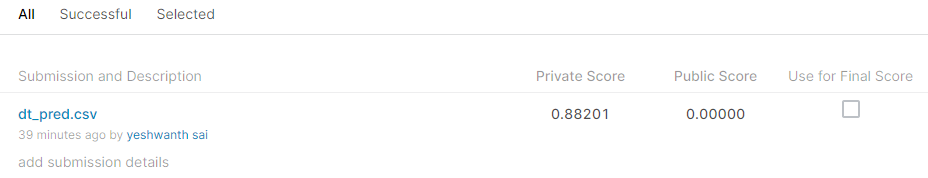

In [20]:
from IPython.display import Image
Image(filename="Best_kaggle_private_score.png")

# 7.) Summary

- Understanding basic 80/20 rule i.e most of the revenue will be generated by very few customers
- ML formulation of the business problem using Hurdle model which is combination of both classification and regression
- preprocessing huge train(25.5 GB) and test(7.62GB) datasets by dividing into smaller chunks
- Preprocessing json columns and normalizing them to normal tables.
- Performimg data cleaning by Removing redundant columns by finding out constant columns
- Exploratory data analysis for all the impacting features for generating revenue and writing observations
- The most important idea is time series featurizarion i.e dividing train datasets and test datsets and finding customers who returned after a cooling period and forming a dataframe suitable for classification problem by introducing a 'is_retuned' class label and for regression problem summing the transaction revenue and introducing a 'revenue' class label
- Adding additional features using operations like Max,Min,Count,Mean etc. with respect to that feature.
- Hyperparameter tuning performed on classification and regression models below
    - Logistic regression and Linear regression
    - Decision tree classification and Decision tree regression
    - Random forest classification and Random forest regression
    - LightGBM classification and Light GBM regression
    - XGB classification and XGB regression
    - Deep learning classification and regression
- Decision tree model outperformed compared to powerful models like random forest and LightGBM and gave kaggle leaderboard private score of 0.88201
- So, Decision tree model is best model and it outperformed compared to other models
- Got 2nd rank(top 1 %) on Kaggle private score leaderboard